# Анализ причин роста CPA для размещаемых рекламных кампаний

**Задачи:**
Рекламодатель Сигма фиксирует постоянный рост CPA по своим рекламным кампаниям в последние 4 месяца (с июня по сент 2022). Необходимо проанализировать его размещение с целью:
- Выяснить причину растущего CPA;
- Дать рекомендации по снижению и стабилизации CPA до целевого значения (380 руб.).

Описание датасета (из условия задачи):
- Client – название клиента (клиента Яндекс.Директ - Заказчика рекламы);
- Device – тип устройства;
- Place – тип площадки;
- BannerType – тип объявления;
- QueryType – тип запроса;
- TargetingType – тип таргетинга;
- Cost - расходы рекламодателя (затраты на рекламу);
- Conversions – целевые визиты (визиты, посещения, когда пользователь совершал целевые действия).

## Краткий ход исследования:

- Предобработка данных:
    - проверка и изменение типов данных;
    - изменение названий столбцов (полей);
    - проверка на дубликаты:
        - проверка полных дубликатов;
        - проверка частичных (логических дубликатов);
    - работа с пропусками:
        - общая информация о пропусках в данных;
        - определение типов пропусков для каждой переменной; 
        - обработка пропусков;
        - удаление данных с пропусками в нескольких полях;
        - проверка долей и кол-ва оставшихся пропусков.
- Исследовательский анализ:
    - Стоимость целевого действия;
    - Сегментирование клиентов:
        - Телефоны и ПК;
        - Группы объявлений (категории услуг);
        - Типы площадок размещения рекламных объявлений;
        - Типы объявлений;
        - Типы таргетинга;
    - Проверка полученных результатов:
        - Определение ориентировочных значений СРА для разных типов рекламы по данным рекламодателей-конкурентов;
    - Работа с воронкой продукта:
        - Измерение CTR и CR для группы объявлений;
        - Расчет конверсий рекламодателей-конкурентов с самым низким СРА для оценки метрик воронки;
        - Проверка конверсий для проблемных подгрупп объявлений;
        - Определение самой эффективной подгруппы в группе объявлений "РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ";
- Выводы и рекомендации по результатам исследования.

In [1]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Отключение научной нотации
pd.options.display.float_format = '{:20,.3f}'.format

In [2]:
# Добавим код для предотвращения появления предупреждений
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
# Блок кода для расположения всех графиков по центру
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
# Получим исходный датасет
df = pd.read_excel('Задание_стажировка_рекламный аналитик_2023.xlsx', sheet_name = 'data')

# Скопируем исходные "сырые" данные, чтобы к ним можно было обратиться
raw_data = df

In [5]:
# Сделаем обзор данных - сначала выведем весь датасет
df.sort_values(by = 'Month')

,Client,Month,Category,Device,Place,BannerType,QueryType (search only),TargetingType,Shows,Clicks,Cost,Conversions
0,Псилон,2021-04-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Networks,cpc_video,none,Phrase,0,0,0.000,0
7459,Псилон,2021-04-01,ИНВЕСТИЦИИ,Desktop,Networks,image_ad,none,Phrase,0,0,0.000,0
7460,Псилон,2021-04-01,ИНВЕСТИЦИИ,Desktop,Networks,image_ad,none,Retargeting,126283,126,"5,849.732",0
7461,Псилон,2021-04-01,ИНВЕСТИЦИИ,Mobile,Networks,image_ad,none,Retargeting,15611,247,"2,565.102",0
7462,Псилон,2021-04-01,ИНВЕСТИЦИИ,Desktop,Search,mcbanner,Brand,Phrase,8,0,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1874,Псилон,2022-09-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Mobile,Search,text,Competitor,Autotargeting,111,2,66.938,0
1875,Псилон,2022-09-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Mobile,Search,text,Competitor,Phrase,9559,426,"48,521.886",1
1876,Псилон,2022-09-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Mobile,Search,text,Other,Autotargeting,8924,499,"13,676.201",0
1870,Псилон,2022-09-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Search,text,Other,Phrase,56517,2896,"529,560.013",65


In [6]:
# Используем функцию describe() для первичного описания количественных переменных
df.describe()

,Shows,Clicks,Cost,Conversions
count,"10,478.000","10,478.000","10,478.000","10,478.000"
mean,"1,715,048.613","9,769.437","359,829.318",507.982
std,"15,449,238.735","44,548.193","1,211,802.193","2,086.405"
min,0.000,0.000,0.000,0.000
25%,1.000,0.000,0.000,0.000
50%,"11,811.500",280.500,"13,046.766",2.000
75%,"132,642.500","5,130.250","211,153.426",94.000
max,"583,150,600.000","2,237,376.000","39,766,179.118","47,259.000"


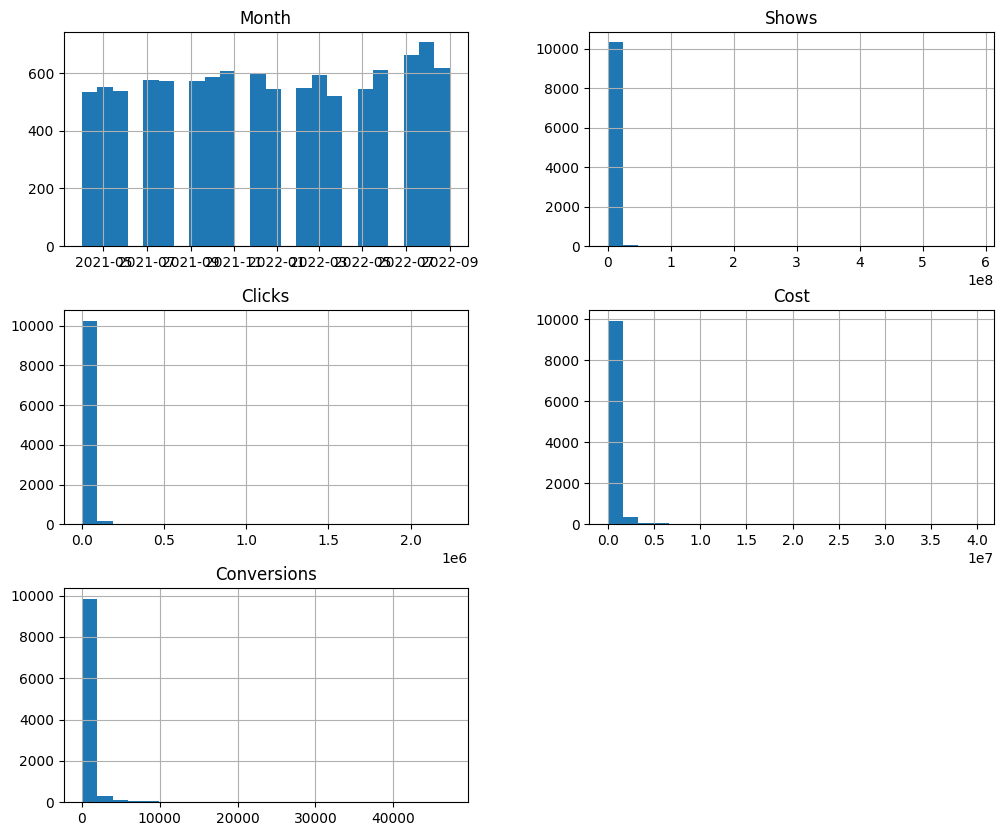

In [7]:
# Построим набор гистограмм
df.hist(figsize = (12, 10), bins = 24);

**Комментарии:** условия задания были неполные - в датасете больше данных. Опишем их:
- Month - месяц;
- Category - группа объявлений (категория услуг);
- Shows - показы рекламы;
- Clicks - клики рекламы.

Прочие наблюдения:
- По обзору данных видно, что они были собраны за апрель 2021 - сентябрь 2022 г., т.е. за полтора года. Равномерность сбора данных по месяцам примерно одинаковая;
- Распределения значений количественных переменных ненормальное. Назвать это распределением Пуассона также не получается - необходимо строить гистограммы отдельно для каждой переменной;
- Очень много качественных переменных - по ним можно будет сделать много разрезов данных, чтобы рассмотреть ситуацию более детально.

## Предобработка данных

### Проверка и изменение типов данных

In [8]:
# Проверим типы данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10478 entries, 0 to 10477
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Client                   10478 non-null  object        
 1   Month                    10478 non-null  datetime64[ns]
 2   Category                 10478 non-null  object        
 3   Device                   10478 non-null  object        
 4   Place                    10478 non-null  object        
 5   BannerType               10478 non-null  object        
 6   QueryType (search only)  10478 non-null  object        
 7   TargetingType            10478 non-null  object        
 8   Shows                    10478 non-null  int64         
 9   Clicks                   10478 non-null  int64         
 10  Cost                     10478 non-null  float64       
 11  Conversions              10478 non-null  int64         
dtypes: datetime64[ns](1), float64(1)

**Комментарии:** изменение типов данных не требуется.

### Изменение названий столбцов (полей)

**Комментарии:** явных ошибок в названии полей нет, поэтому для удобства восприятия информации оставим их названия без изменений.

### Проверка на дубликаты

#### Проверка на полные дубликаты

In [9]:
# Проверим данные на наличие дубликатов
print(f'Кол-во полных дубликатов строк составляет {df.duplicated().sum()} шт.')

Кол-во полных дубликатов строк составляет 0 шт.


#### Проверка на частичные дубликаты

Поищем частичные дубликаты по стоимости: 

In [10]:
# Проверим набор данных на неполные дубликаты по полю 'Cost'
duplicated_data = df[df.duplicated(subset = ['Cost']) == True]
duplicated_data

,Client,Month,Category,Device,Place,BannerType,QueryType (search only),TargetingType,Shows,Clicks,Cost,Conversions
4,Гамма,2021-04-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Mobile,Networks,image_ad,none,Retargeting,18,0,0.000,0
6,Дельта,2021-04-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Mobile,Networks,image_ad,none,Phrase,0,0,0.000,0
13,Омега,2021-04-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Mobile,Networks,image_ad,none,Retargeting,6,0,0.000,0
19,Гамма,2021-04-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Desktop,Search,mcbanner,Other,Phrase,2,0,0.000,0
20,Гамма,2021-04-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Mobile,Search,mcbanner,Brand,Phrase,29,0,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10470,Зета,2022-09-01,ВКЛАДЫ,Mobile,Search,text,Brand,Phrase,0,0,0.000,0
10471,Псилон,2022-09-01,ВКЛАДЫ,Desktop,Networks,text,none,Phrase,0,0,0.000,0
10472,Псилон,2022-09-01,ВКЛАДЫ,Desktop,Networks,text,none,Retargeting,0,0,0.000,0
10474,Псилон,2022-09-01,ВКЛАДЫ,Desktop,Search,text,Other,Phrase,1,0,0.000,0


In [11]:
# Выведем уникальные значения
display('Уникальные значения по полю "Стоимость"', duplicated_data.Cost.unique())
display('Уникальные значения по полю "Показы"', duplicated_data.Shows.sort_values().unique())
display('Уникальные значения по полю "Клики"',duplicated_data.Clicks.sort_values().unique())

'Уникальные значения по полю "Стоимость"'

array([0.])

'Уникальные значения по полю "Показы"'

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
         44,   45,   46,   47,   48,   49,   50,   52,   53,   54,   55,
         56,   57,   58,   59,   60,   61,   62,   63,   64,   65,   66,
         67,   68,   69,   70,   72,   73,   74,   75,   76,   77,   78,
         79,   80,   81,   82,   83,   85,   86,   88,   89,   92,   93,
         94,   95,   96,   97,   98,  101,  103,  104,  105,  106,  109,
        110,  112,  113,  114,  115,  117,  118,  119,  121,  122,  123,
        124,  125,  127,  128,  130,  132,  138,  140,  146,  147,  150,
        151,  153,  154,  155,  161,  162,  166,  169,  171,  177,  178,
        180,  183,  185,  186,  191,  196,  201,  202,  205,  208,  210,
        221,  225,  227,  228,  232,  234,  236,  2

'Уникальные значения по полю "Клики"'

array([0], dtype=int64)

**Комментарии:** по стоимости частичных дубликатов нет - есть реклама с ненулевыми показами, однако по ним нет ни одного клика, соответственно и стоимость нулевая. Но таких данных достаточно много, порядка 30%.

У нас есть ненулевые значения в дубликатах - выведем их из обрабатываемого датасета:

### Работа с пропусками

In [12]:
# Выведем кол-во пропусков в каждом поле
df.isna().sum().sort_values(ascending=False)

Client                     0
Month                      0
Category                   0
Device                     0
Place                      0
BannerType                 0
QueryType (search only)    0
TargetingType              0
Shows                      0
Clicks                     0
Cost                       0
Conversions                0
dtype: int64

**Комментарии:** пропуски отсутствуют. Данные готовы к проведению исследовательского анализа.

## Исследовательский анализ

### Стоимость целевого действия

**CPA (Cost Per Action, стоимость обращения)** показывает, сколько стоит целевой визит посетителя. CPA — отношение рекламного бюджета (затрат на рекламу) к количеству обращений (целевых визитов):

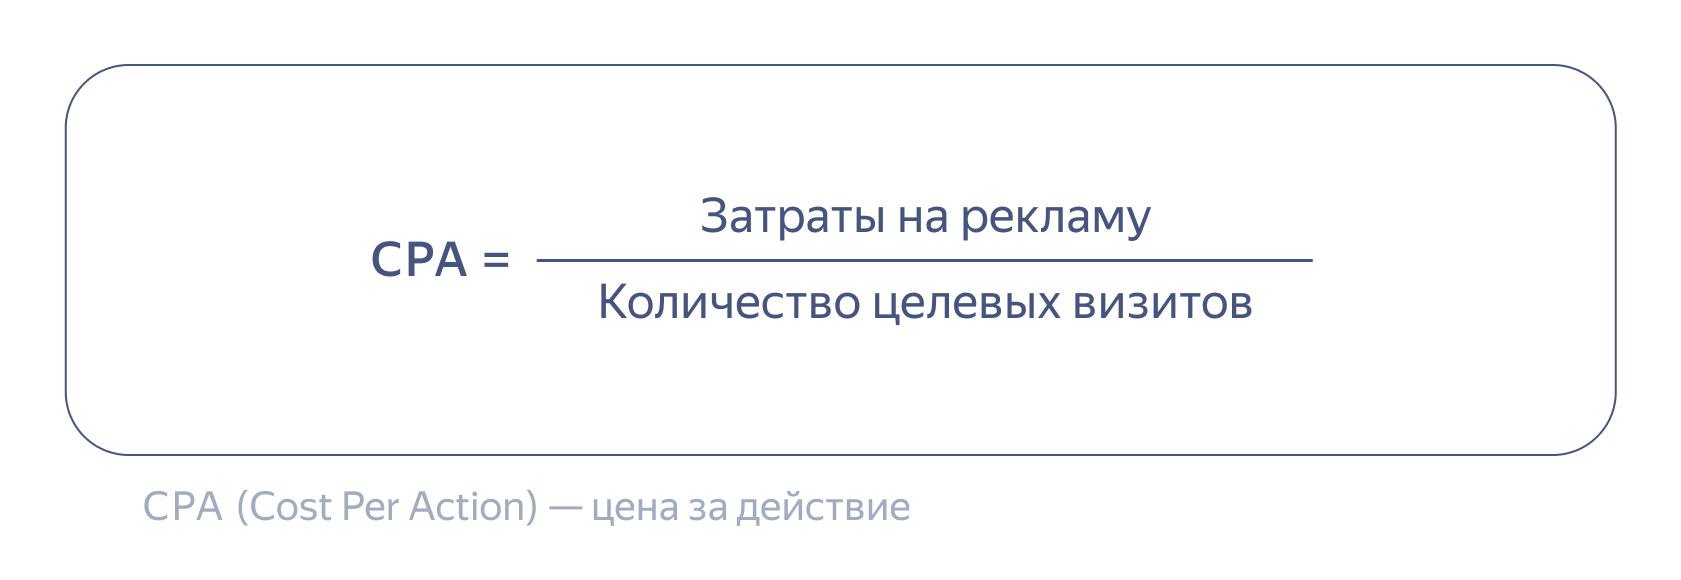

По сути данная метрика показывает нам стоимость нашего "лида", поэтому очень важна для расчетов. Целевой уровень этой метрики задан Заказчиком и равен 380 руб.

А под **целевым визитом** понимается такое посещение сайта, в процессе которого посетитель сделал `целевое действие`, установленное рекламодателем. Например, оформил заявку на информирование по условиям вкладов или совершил регистрацию на сайте.

Для улучшения значения CPA существуют следующие основные способы:
- сегментирование клиентов (по каналу привлечения, категории услуг);
- работа с воронкой продукта;
- работа с качеством каналов и объявлений;
- влияние на монетизацию и бизнес-модель (выполняется на стороне бизнеса).

Необходимо учитывать, что ввиду ограниченности данных мы не сможем проверить качество каналов и объявлений (элементарно нет доступа к креативам, видео и `ключевым фразам`), однако сможем проверить сегменты клиентов по категории услуг и воронку от показа рекламы до осуществления целевого действия. 

Для начала убедимся, действительно ли есть проблема с ростом CPA - построим линейный график для рекламодателя "Сигма" за 2022 год, с учетом целевого уровня:

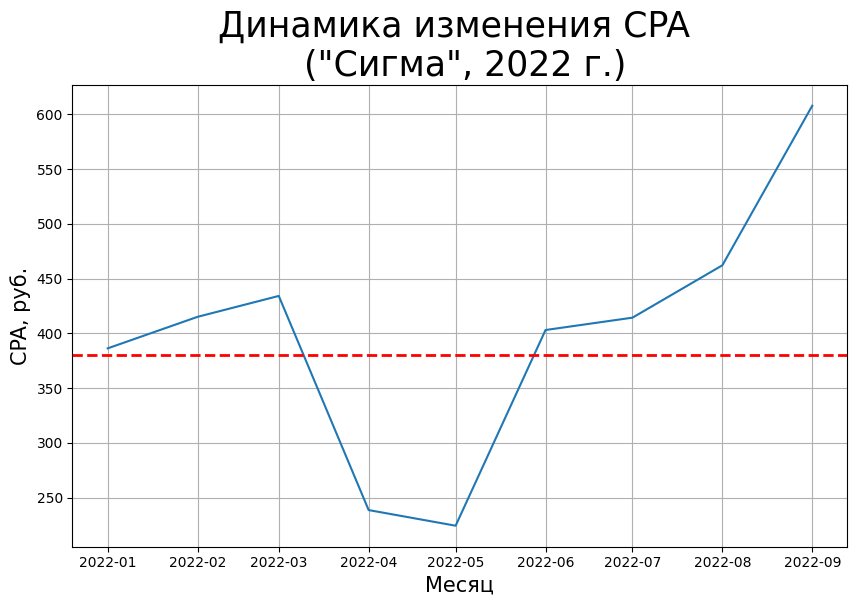

In [13]:
# Подготовим данные для построения графика изменения CPA 
data_for_charts_sigma = df[(df['Client'] == 'Сигма') & (df['Month'] > '2021-12-01')]\
                        .groupby('Month', as_index = False).agg({'Clicks': 'sum', 'Cost': 'sum', 'Conversions': 'sum'})

# Рассчитаем CPA
data_for_charts_sigma['CPA'] = data_for_charts_sigma['Cost'] / data_for_charts_sigma['Conversions']

# Построим линейный график
plt.figure(figsize = (10, 6))
ax = sns.lineplot(x = data_for_charts_sigma['Month'], y = np.array(data_for_charts_sigma['CPA']))
plt.title('Динамика изменения CPA \n ("Сигма", 2022 г.)', fontsize = 25)
plt.xlabel('Месяц', fontsize = 15)
plt.ylabel('CPA, руб.', fontsize = 15)
plt.grid()

# Добавим индикатор целевого значения CPA
plt.axhline(y=380, color='r', linestyle='dashed', linewidth=2)
plt.show()

Проблематика действительно есть: в июне средний CPA уже превышал 400 руб., а в сентябре - 600 руб (примерно на 50% выше целевого уровня).

Также исходя из порядка полученных числовых значений можно утверждать, что речь идет о каком-то одном конкретном целевом действии (а на сайте их может быть несколько, с разной ценностью: https://yandex.ru/support/direct/strategies/priority-goals.html).

### Сегментирование клиентов

#### Телефоны и ПК

CPA может быть рассчитана по разным `платформам`, `каналам привлечения (категория услуг)`, `рекламным кампаниям`. Построим графики CPA для телефонов и ПК:

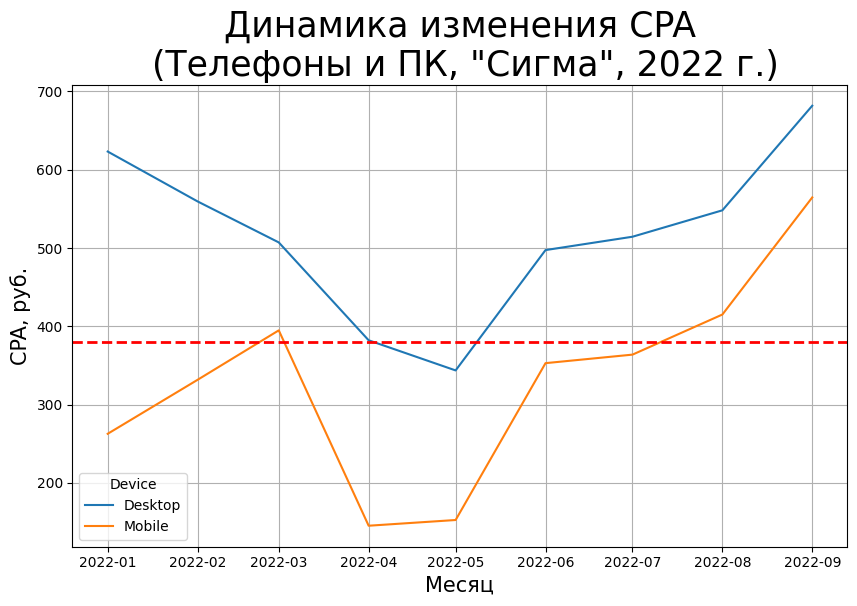

In [14]:
# Подготовим данные
cpa_device_chart = df[(df['Client'] == 'Сигма') & (df['Month'] > '2021-12-01')]\
                        .groupby(['Month', 'Device'], as_index = False)\
                        .agg({'Clicks': 'sum', 'Cost': 'sum', 'Conversions': 'sum'})

# Рассчитаем CPA
cpa_device_chart['CPA'] = cpa_device_chart['Cost'] / cpa_device_chart['Conversions']

# Выведем графики
plt.figure(figsize = (10, 6))
ax = sns.lineplot(x = 'Month', y = 'CPA', hue = 'Device', data = cpa_device_chart)
plt.title('Динамика изменения CPA\n (Телефоны и ПК, "Сигма", 2022 г.)', fontsize = 25)
plt.xlabel('Месяц', fontsize = 15)
plt.ylabel('CPA, руб.', fontsize = 15)
plt.grid()

# Добавим индикатор целевого значения CPA и выведем графики на экран
plt.axhline(y=380, color='r', linestyle='dashed', linewidth=2)
plt.show()

Очевидно, что для мобильных телефонов ситуация с CPA обстоит намного лучше, однако как для ПК, так и для мобильных телефонов наблюдается динамика роста CPA, а значит проблема не в типе устройства. 

#### Группы объявлений (категории услуг)

Сделаем разбивку по `группам (категориям) объявлений (категории услуг)`, сохранив при этом разбивку по устройствам: 

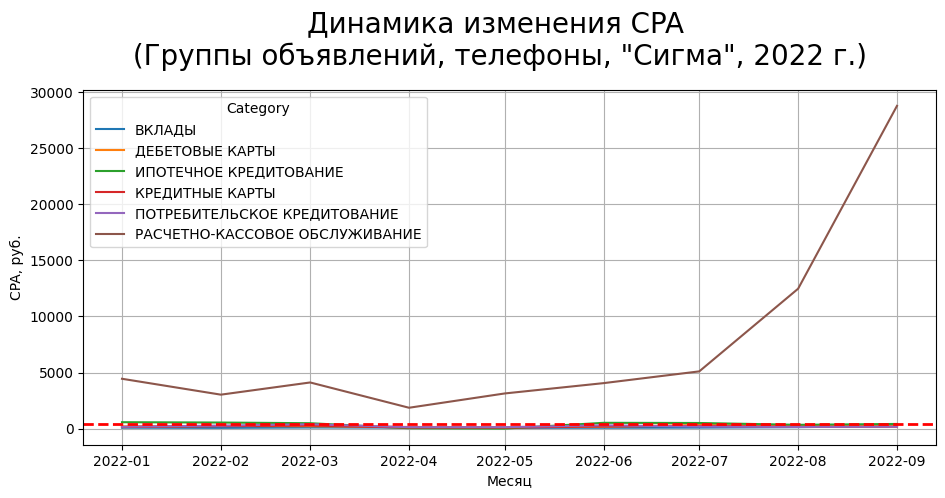

In [15]:
# Подготовим данные
cpa_category_chart = df[(df['Client'] == 'Сигма') & (df['Month'] > '2021-12-01')]\
                        .groupby(['Month', 'Device', 'Category'], as_index = False)\
                        .agg({'Clicks': 'sum', 'Cost': 'sum', 'Conversions': 'sum'})

# Рассчитаем CPA
cpa_category_chart['CPA'] = cpa_category_chart['Cost'] / cpa_category_chart['Conversions']

# Поделим график на платформы
cpa_mobile = cpa_category_chart[cpa_category_chart['Device'] == 'Mobile']
cpa_desktop = cpa_category_chart[cpa_category_chart['Device'] == 'Desktop']

# Построим график для мобильных устройств
fig = plt.figure(figsize = (11, 5))
fig.suptitle('Динамика изменения CPA\n (Группы объявлений, телефоны, "Сигма", 2022 г.)', fontsize = 20)
plt.subplots_adjust(top = 0.82)
axs = sns.lineplot(x = 'Month', y = 'CPA', hue = 'Category', data = cpa_mobile)
plt.xlabel('Месяц')
plt.ylabel('CPA, руб.')
plt.grid()

# Добавим индикатор целевого значения CPA и выведем графики на экран
plt.axhline(y=380, color='r', linestyle='dashed', linewidth=2)
plt.show()

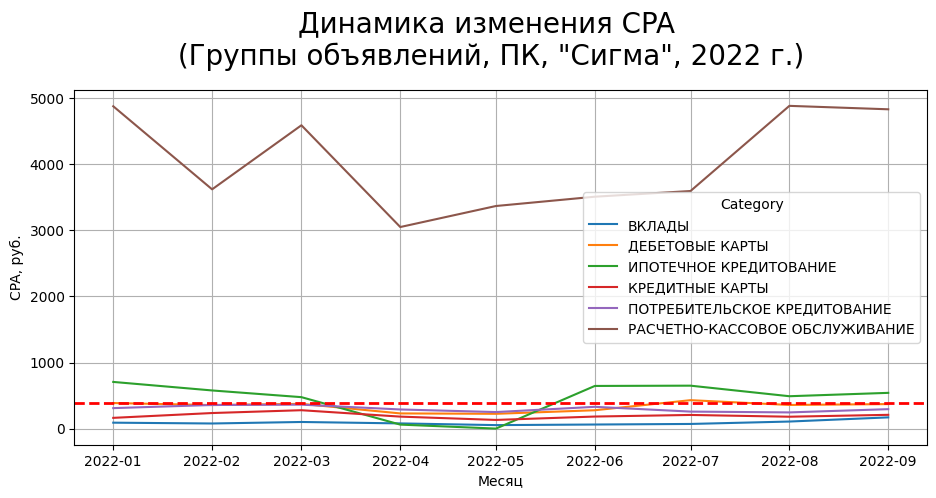

In [16]:
# Построим график для ПК
fig = plt.figure(figsize = (11, 5))
fig.suptitle('Динамика изменения CPA\n (Группы объявлений, ПК, "Сигма", 2022 г.)', fontsize = 20)
plt.subplots_adjust(top = 0.82)
axs = sns.lineplot(x = 'Month', y = 'CPA', hue = 'Category', data = cpa_desktop)
plt.xlabel('Месяц')
plt.ylabel('CPA, руб.')
plt.grid()

# Добавим индикатор целевого значения CPA и выведем графики на экран
plt.axhline(y=380, color='r', linestyle='dashed', linewidth=2)
plt.show()

Очевидно, что CPA для группы объявлений "РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ" значительно выше целевого уровня для обоих платформ. Причем ситуация обстоит хуже для мобильных телефонов, а для ПК характер изменения CPA отличается - нет резкого роста значения с июля 2022 г. и значение CPA стабильно высокие. 

Также на ПК есть СРА у группы объявлений "ИПОТЕЧНОЕ КРЕДИТОВАНИЕ" выше целевого уровня. Чтобы понять, норма это или нет, необходимо сравнить полученные результаты с СРА конкурентов в данной категории услуг.

На этом этапе уже могут быть проблемы с `ключевыми фразами` и `минус-словами`, которые задаются или на всю группу сразу, или на каждое отдельное объявление. 

#### Типы площадок размещения рекламных объявлений

Попробуем конкретизировать - возможно есть проблема в каком-то конкретном `месте размещения`, `типе объявлений`, `типе таргетинга` или `воронке пользователей от показов до совершения целевого действия`. Для начала проверим CPA для каждого типа площадки для мобильных телефонов и ПК: 

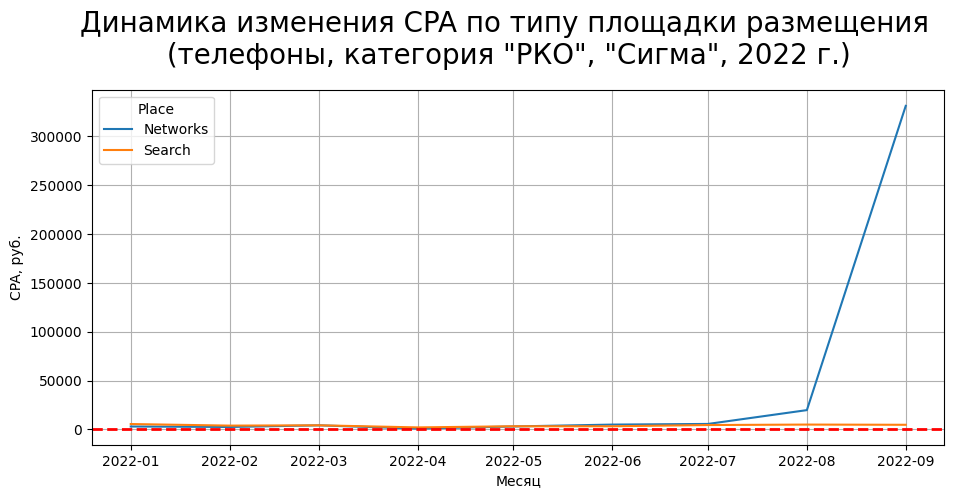

In [17]:
# Подготовим данные
cpa_chart_place = df[(df['Client'] == 'Сигма')\
                     & (df['Month'] > '2021-12-01')\
                     & (df['Category'] == 'РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ')]\
                     .groupby(['Month', 'Device', 'Place'], as_index = False)\
                     .agg({'Clicks': 'sum', 'Cost': 'sum', 'Conversions': 'sum'})

# Рассчитаем CPA
cpa_chart_place['CPA'] = cpa_chart_place['Cost'] / cpa_chart_place['Conversions']

# Поделим график на платформы
cpa_mobile_place = cpa_chart_place[cpa_chart_place['Device'] == 'Mobile']
cpa_desktop_place = cpa_chart_place[cpa_chart_place['Device'] == 'Desktop']

# Построим график для мобильных устройств
fig = plt.figure(figsize = (11, 5))
fig.suptitle('Динамика изменения CPA по типу площадки размещения\n (телефоны, категория "РКО", "Сигма", 2022 г.)',\
             fontsize = 20)
plt.subplots_adjust(top = 0.82)
axs = sns.lineplot(x = 'Month', y = 'CPA', hue = 'Place', data = cpa_mobile_place)
plt.xlabel('Месяц')
plt.ylabel('CPA, руб.')
plt.grid()

# Добавим индикатор целевого значения CPA и выведем графики на экран
plt.axhline(y=380, color='r', linestyle='dashed', linewidth=2)
plt.show()

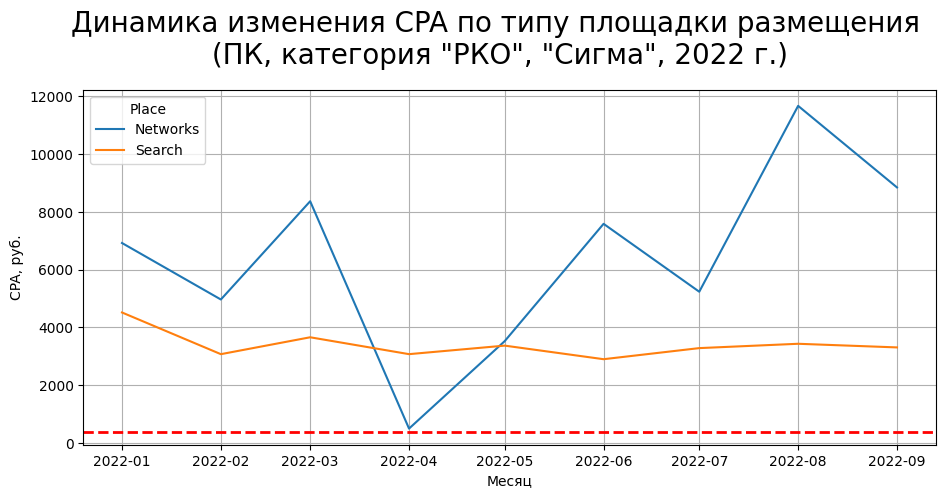

In [18]:
# Построим график для ПК
fig = plt.figure(figsize = (11, 5))
fig.suptitle('Динамика изменения CPA по типу площадки размещения\n (ПК, категория "РКО", "Сигма", 2022 г.)',\
             fontsize = 20)
plt.subplots_adjust(top = 0.82)
axs = sns.lineplot(x = 'Month', y = 'CPA', hue = 'Place', data = cpa_desktop_place)
plt.xlabel('Месяц')
plt.ylabel('CPA, руб.')
plt.grid()

# Добавим индикатор целевого значения CPA и выведем графики на экран
plt.axhline(y=380, color='r', linestyle='dashed', linewidth=2)
plt.show()

Проблемы с СРА есть как в поисковой строке (Search), так и в Интернете (Networks). Однако для мобильных телефонов она приобретает глобальное значение - СРА превышает 300 000 рублей.

#### Типы объявлений

Построим графики СРА для каждого отдельного типа объявлений (типа рекламы) - для мобильных телефонов и ПК:

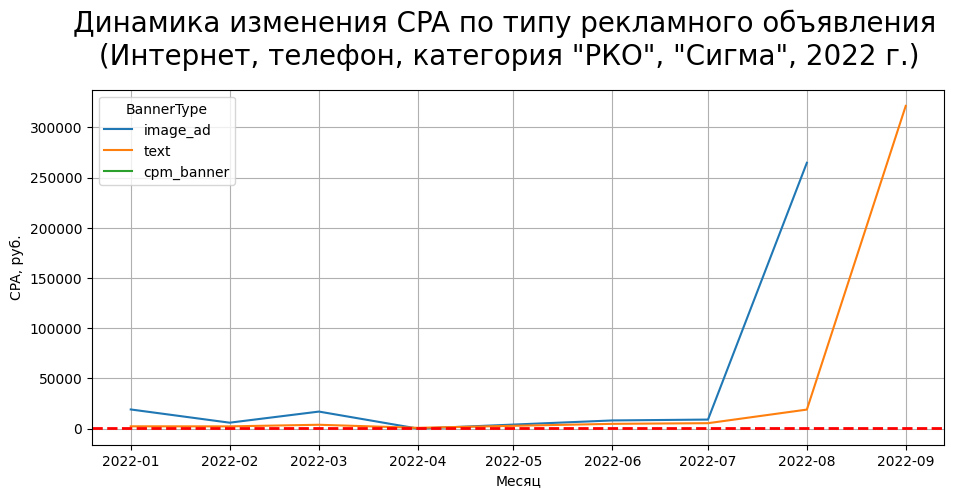

In [19]:
# Подготовим данные
cpa_chart_banner = df[(df['Client'] == 'Сигма')\
                     & (df['Month'] > '2021-12-01')\
                     & (df['Category'] == 'РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ')
                     & (df['Place'] == 'Networks')]\
                     .groupby(['Month', 'Device', 'BannerType'], as_index = False)\
                     .agg({'Clicks': 'sum', 'Cost': 'sum', 'Conversions': 'sum'})

# Рассчитаем CPA
cpa_chart_banner['CPA'] = cpa_chart_banner['Cost'] / cpa_chart_banner['Conversions']

# Поделим график на платформы
cpa_mobile_banner = cpa_chart_banner[cpa_chart_banner['Device'] == 'Mobile']
cpa_desktop_banner = cpa_chart_banner[cpa_chart_banner['Device'] == 'Desktop']

# Построим график для мобильных устройств
fig = plt.figure(figsize = (11, 5))
fig.suptitle('Динамика изменения CPA по типу рекламного объявления\n (Интернет, телефон, категория "РКО", "Сигма", 2022 г.)',\
             fontsize = 20)
plt.subplots_adjust(top = 0.82)
axs = sns.lineplot(x = 'Month', y = 'CPA', hue = 'BannerType', data = cpa_mobile_banner)
plt.xlabel('Месяц')
plt.ylabel('CPA, руб.')
plt.grid()

# Добавим индикатор целевого значения CPA и выведем графики на экран
plt.axhline(y=380, color='r', linestyle='dashed', linewidth=2)
plt.show()

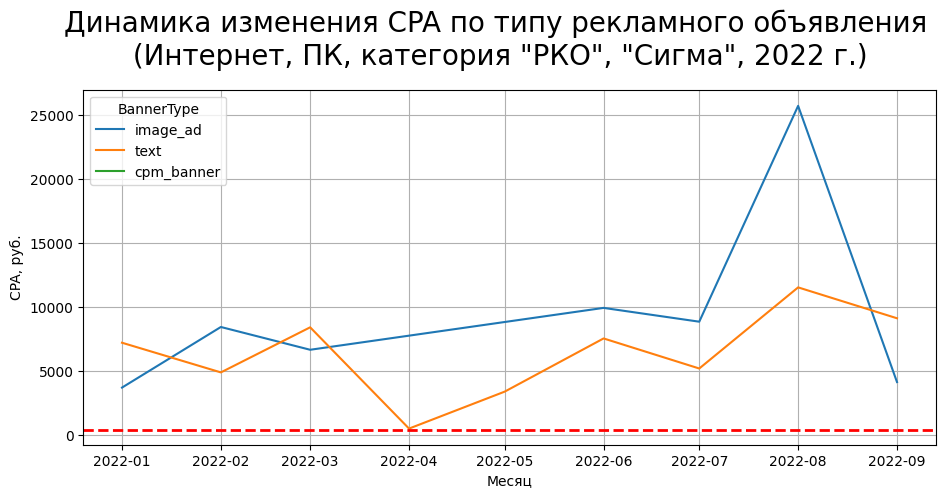

In [20]:
# Построим график для ПК
fig = plt.figure(figsize = (11, 5))
fig.suptitle('Динамика изменения CPA по типу рекламного объявления\n (Интернет, ПК, категория "РКО", "Сигма", 2022 г.)',\
             fontsize = 20)
plt.subplots_adjust(top = 0.82)
axs = sns.lineplot(x = 'Month', y = 'CPA', hue = 'BannerType', data = cpa_desktop_banner)
plt.xlabel('Месяц')
plt.ylabel('CPA, руб.')
plt.grid()

# Добавим индикатор целевого значения CPA и выведем графики на экран
plt.axhline(y=380, color='r', linestyle='dashed', linewidth=2)
plt.show()

Ситуация повторяется: для мобильных телефонов есть резкий рост CPA для текстовых рекламных объявлений (тип 'text') и текстовых рекламных объявлений с изображением (тип 'image_ad').

#### Типы таргетинга

Проверим CPA для разных типов таргетинга по следующим параметрам:
- платформа - мобильные телефоны;
- место показа - Интернет (РСЯ);
- типы рекламы: "текст" и "текст с изображением".

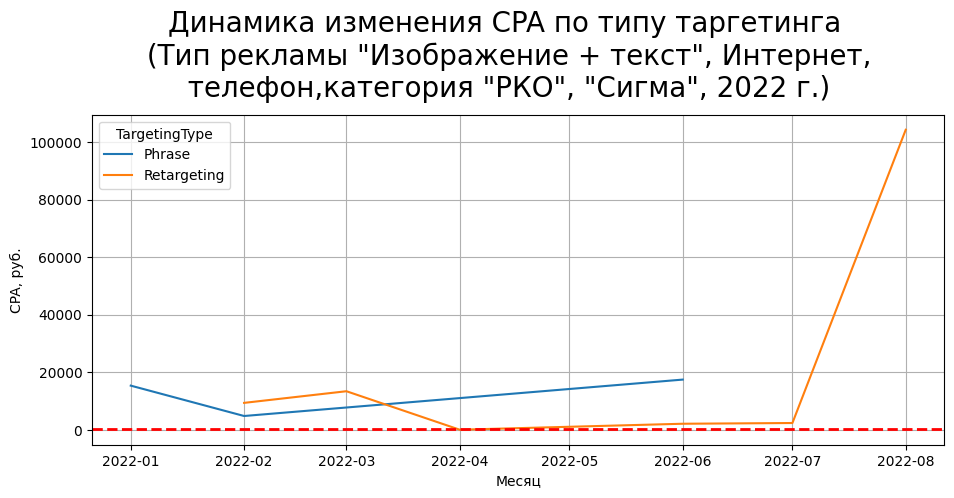

In [21]:
# Подготовим данные
cpa_chart_targeting = df[(df['Client'] == 'Сигма')\
                       & (df['Month'] > '2021-12-01')\
                       & (df['Category'] == 'РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ')
                       & (df['Device'] == 'Mobile')\
                       & (df['Place'] == 'Networks')]\
                         .groupby(['Month', 'BannerType', 'TargetingType'], as_index = False)\
                         .agg({'Clicks': 'sum', 'Cost': 'sum', 'Conversions': 'sum'})

# Рассчитаем CPA
cpa_chart_targeting['CPA'] = cpa_chart_targeting['Cost'] / cpa_chart_targeting['Conversions']

# Поделим данные по типам рекламы
cpa_banner_image = cpa_chart_targeting[cpa_chart_targeting['BannerType'] == 'image_ad']
cpa_banner_text = cpa_chart_targeting[cpa_chart_targeting['BannerType'] == 'text']

# Построим график для рекламы "Изображение + текст"
fig = plt.figure(figsize = (11, 5))
fig.suptitle('Динамика изменения CPA по типу таргетинга\n (Тип рекламы "Изображение + текст", Интернет,\n телефон,\
категория "РКО", "Сигма", 2022 г.)',\
             fontsize = 20)
plt.subplots_adjust(top = 0.77)
axs = sns.lineplot(x = 'Month', y = 'CPA', hue = 'TargetingType', data = cpa_banner_image)
plt.xlabel('Месяц')
plt.ylabel('CPA, руб.')
plt.grid()

# Добавим индикатор целевого значения CPA и выведем графики на экран
plt.axhline(y=380, color='r', linestyle='dashed', linewidth=2)
plt.show()

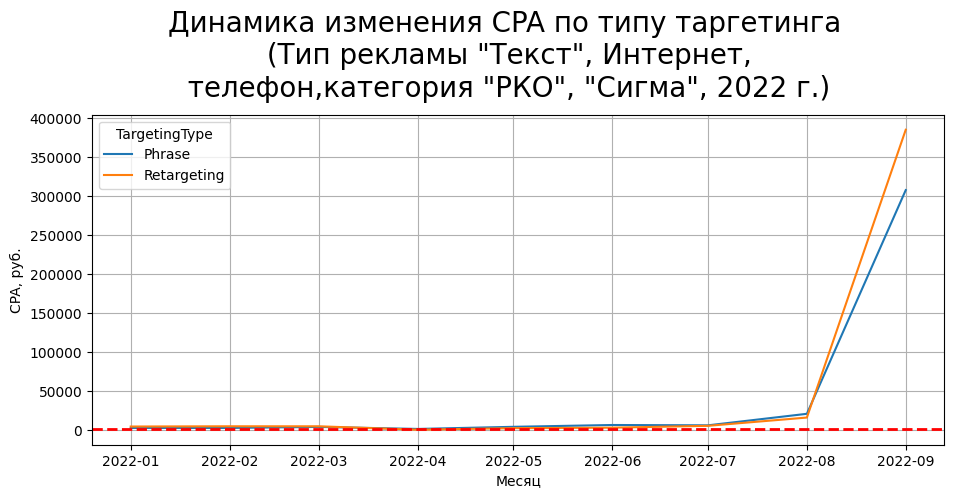

In [22]:
# Построим график для типа рекламы "Текст"
fig = plt.figure(figsize = (11, 5))
plt.suptitle('Динамика изменения CPA по типу таргетинга\n (Тип рекламы "Текст", Интернет,\n телефон,\
категория "РКО", "Сигма", 2022 г.)',\
             fontsize = 20)
plt.subplots_adjust(top = 0.77)

axs = sns.lineplot(x = 'Month', y = 'CPA', hue = 'TargetingType', data = cpa_banner_text)
plt.xlabel('Месяц')
plt.ylabel('CPA, руб.')
plt.grid()

# Добавим индикатор целевого значения CPA и выведем графики на экран
plt.axhline(y=380, color='r', linestyle='dashed', linewidth=2)
plt.show()

**Таргетинг** — это выбор целевой аудитории `объявления` (`группы объявлений`) и определение условий показа. Для этого настраивают параметры кампаний, групп объявлений, фраз.

В нашем датасете есть три ключевых типа таргетинга:
- Phrase или **Ключевые фразы** — это слова или словосочетания, которые определяют, кому будет показано ваше объявление. Условно примем, что здесь у нас пословное соответствие (нет флага на семантические ключевые фразы) https://yandex.ru/support/direct/keywords/keywords.html. Т.е. `в данном случае таргетинг происходит только по ключевым словам`;
- Retargeting или **Ретаргетинг и подбор аудитории** — это способ показывать объявления только интересующим вас пользователям. Например, тем, кто посетил сайт и положил товар в корзину (`повторный показ рекламы`). Выделить группу пользователей можно с помощью Яндекс Метрики и Яндекс Аудиторий. Объявления по ретаргетингу и подбору аудитории будут показываться на поиске и в сетях (РСЯ и внешние сети).  https://yandex.ru/support/direct/impression-criteria/retargeting-lists.html

- Autotargeting или **Автотаргетинг** — это технология показа объявлений, не использующая ключевые фразы. Она анализирует информацию в объявлении и на странице перехода и определяет, соответствует ли объявление поисковому запросу, интересам пользователя или тематике площадки. Автотаргетинг позволяет получить дополнительный целевой трафик благодаря показам аудитории, которую сложно охватить с помощью ключевых фраз. https://yandex.ru/support/direct/impression-criteria/autotargeting.html

### Проверка полученных результатов

Для того, чтобы убедиться, что проблематика найдена верно, выведем графики изменения CPA в разрезе платформ / мест размещения для каждого конкретного типа рекламы / таргетинга / типа поиска (для поисковой рекламы):

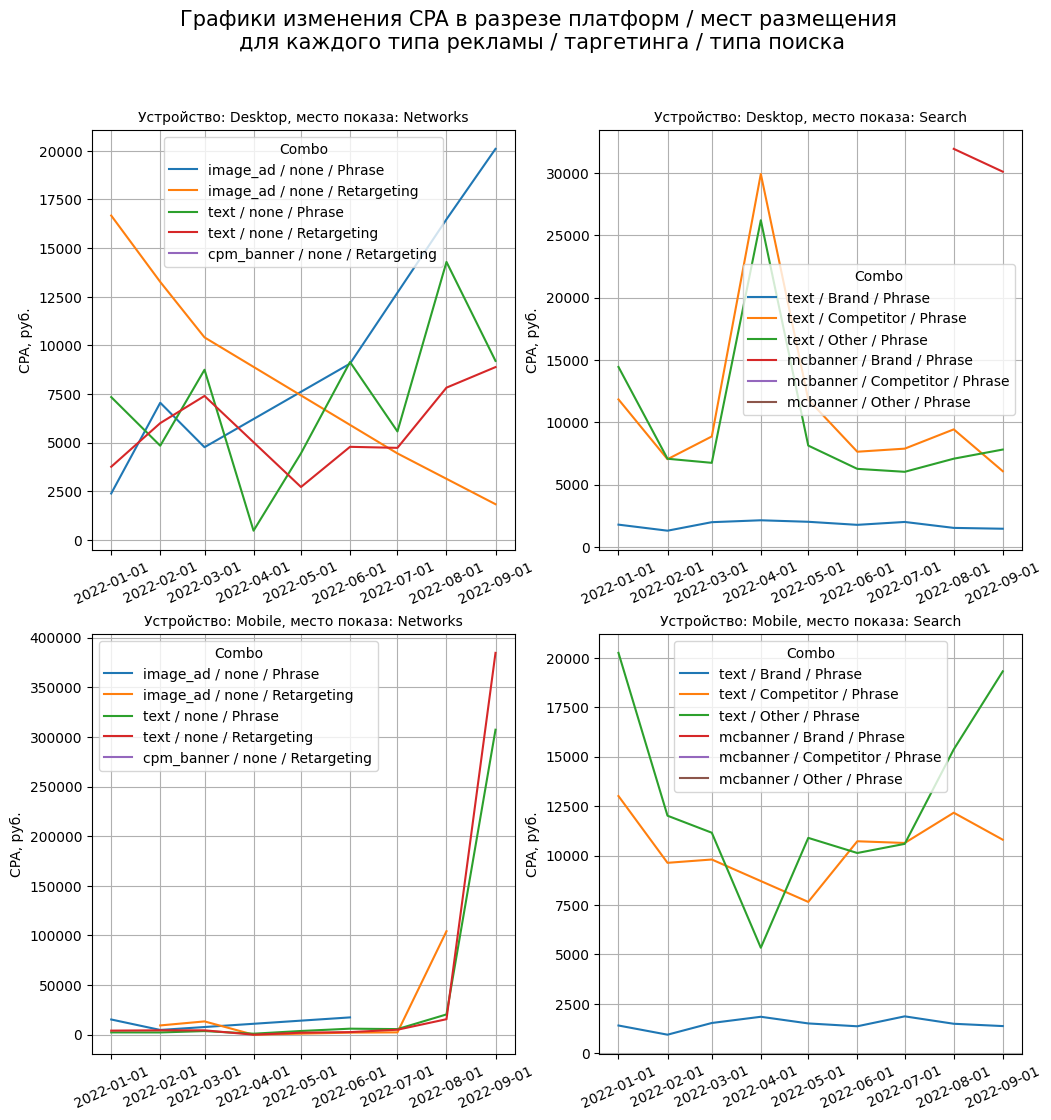

In [23]:
# Подготовим данные для графиков - используем только фильтрацию, т.к. данные уже агрегированы по месяцам и рекламным объявлениям
cpa_each_branch = df[(df['Client'] == 'Сигма')\
                   & (df['Month'] > '2021-12-01')\
                   & (df['Category'] == 'РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ')]\

# Рассчитаем СРА
cpa_each_branch['CPA'] = cpa_each_branch['Cost'] / cpa_each_branch['Conversions']

# Подготовим обозначения для каждого типа рекламного объявления
cpa_each_branch['Combo'] = cpa_each_branch[['BannerType','QueryType (search only)', 'TargetingType']]\
                                            .apply(lambda x :' / '.join(x.astype(str)),1)

# Создадим словарь с параметрами для каждого графика
param_dict = {1: [0, 0, 'Device', 'Desktop', 'Place', 'Networks'],
              2: [0, 1, 'Device', 'Desktop', 'Place', 'Search'],
              3: [1, 0, 'Device', 'Mobile', 'Place', 'Networks'],
              4: [1, 1, 'Device', 'Mobile', 'Place', 'Search']}

# Построим графики
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 12))
fig.suptitle('Графики изменения CPA в разрезе платформ / мест размещения \nдля каждого типа рекламы / таргетинга / типа поиска',\
            size = 15)


for key, value in param_dict.items():
    
    # Построим сами графики в разрезах платформы и места размещения рекламы
    sns.lineplot(x = 'Month', y = 'CPA', hue = 'Combo',\
                 data = cpa_each_branch[(cpa_each_branch[value[2]] == value[3])\
                                      & (cpa_each_branch[value[4]] == value[5])], ax=axs[value[0], value[1]])
    
    # Зададим параметры для каждого графика
    # Подписи осей
    axs[value[0], value[1]].set(xlabel = None, ylabel = 'CPA, руб.')
    
    # Текст заголовка
    title = 'Устройство: ' +  value[3] + ', место показа: ' + value[5]
    
    # Зададим сам заголовок
    axs[value[0], value[1]].set_title(title, size=10)
    
    # Повернем значения оси X
    axs[value[0], value[1]].xaxis.set_ticks(list(pd.DatetimeIndex(cpa_each_branch['Month'].unique()).date.astype(str)))
    axs[value[0], value[1]].set_xticklabels(pd.DatetimeIndex(cpa_each_branch['Month'].unique()).date.astype(str), rotation = 25)
    
    # Зададим сетку для каждого графика
    axs[value[0], value[1]].grid(True) 
    
plt.show()

#### Определение ориентировочных значений СРА для разных типов рекламы по данным рекламодателей-конкурентов

У нас относительно высокий CPA для разных устройств, мест показа и объявлений - если уберем пиковые значения, то CPA будет в диапазоне 0 - 35 000 руб. С одной стороны, это явно выше чем среднее целевое значение СРА в 380 руб. и на первый взгляд может показаться проблемой. С другой стороны для данного типа услуг СРА изначально достаточно высокий:

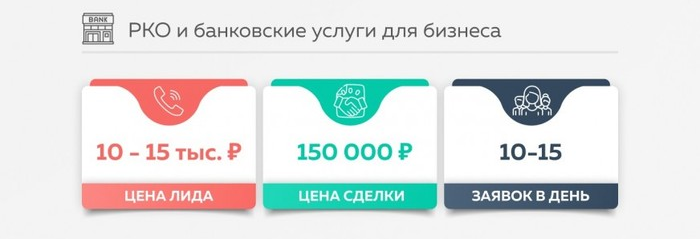

Поэтому, чтобы окончательно определиться с необходимостью делать что-либо с остальными объявлениями в данной группе, проанализируем значения CPA рекламодателей-конкурентов и возьмем лучший показатель за ориентир: 

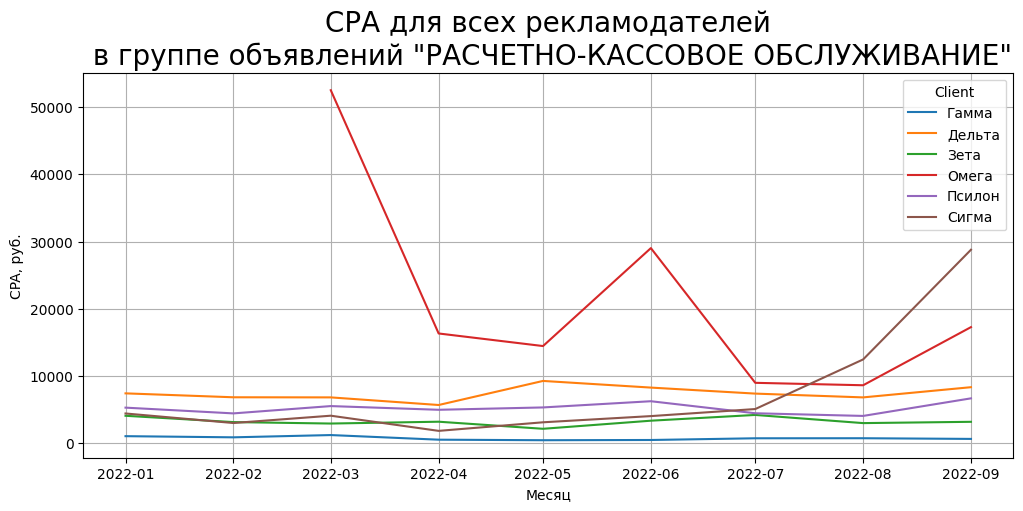

In [24]:
# Подготовим данные для графиков
cpa_charts = df[(df['Device'] == 'Mobile')\
              & (df['Month'] > '2021-12-01')\
              & (df['Category'] == 'РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ')]\
              .groupby(['Client', 'Month']).agg({'Cost': 'sum', 'Conversions': 'sum'})

# Расчитаем СРА для каждого рекламодателя
cpa_charts['CPA'] = cpa_charts['Cost'] / cpa_charts['Conversions']

# Построим график динамики СРА
plt.figure(figsize = (12, 5))
plt.title('СРА для всех рекламодателей\n в группе объявлений "РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ"', size=20)
axs = sns.lineplot(x = 'Month', y = 'CPA', hue = 'Client', data = cpa_charts)
axs.set_xlabel('Месяц')
axs.set_ylabel('CPA, руб.')
plt.grid(True)
plt.show()

Среднее значения СРА у всех рекламодателей (кроме "Омега") держалось примерно на одном уровне - до 10 000 рублей. Однако у заказчика "Сигма" начался резкий рост с июля 2022 г. У "Гамма" самый низкий СРА - это может быть связано как с эффективностью, так и с отсутствием рекламных объявлений по определенным каналам. А у "Зета" СРА на общем уровне и одновременно самое эффективное в локальной группе. Поэтому построим СРА для этих двух рекламодателей в разрезе платформ / мест размещения для каждого конкретного типа рекламы / таргетинга / типа поиска (для поисковой рекламы), как сделали это ранее для "Сигмы":

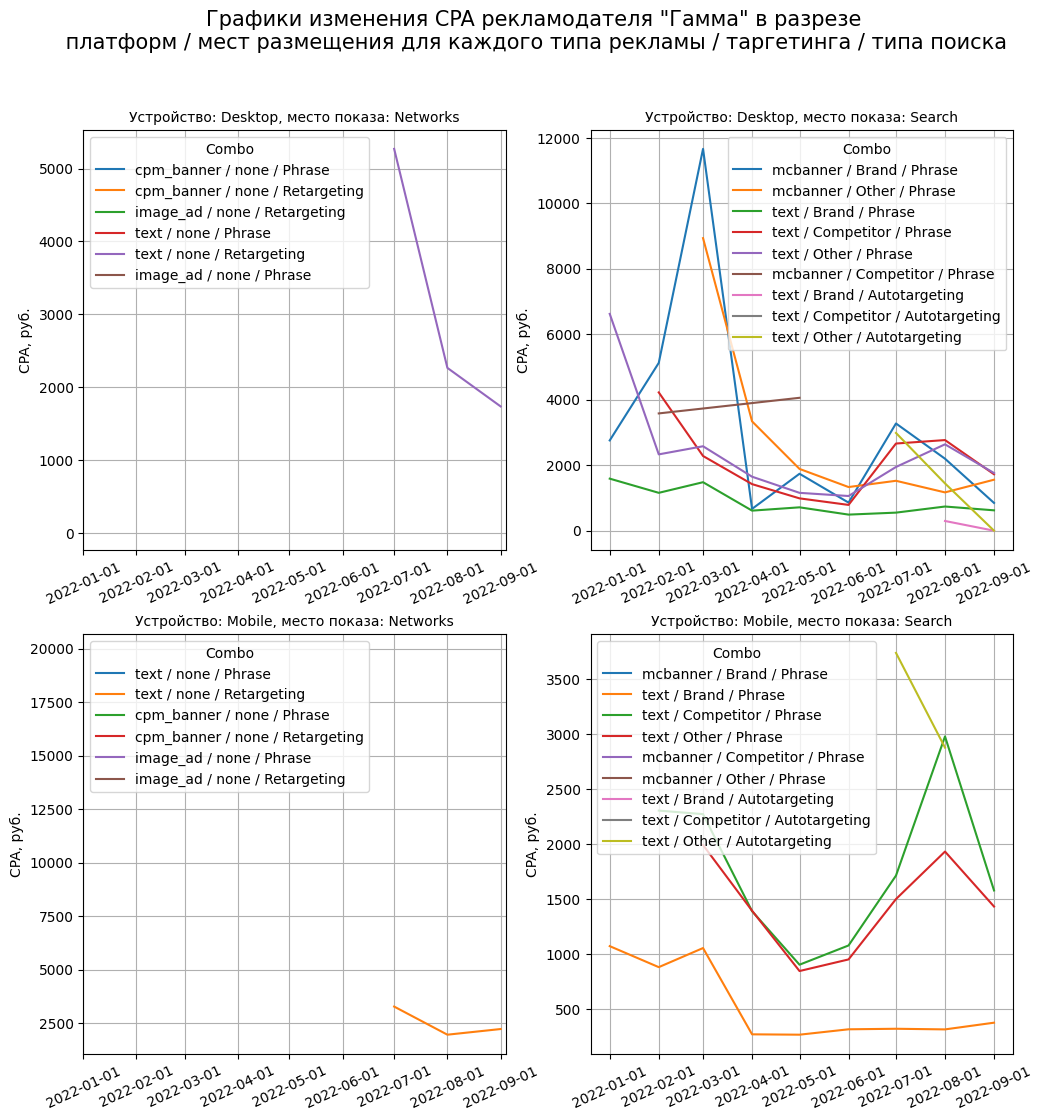

In [25]:
# Подготовим данные для графиков - используем только фильтрацию, т.к. данные уже агрегированы по месяцам и рекламным объявлениям
cpa_each_branch = df[(df['Client'] == 'Гамма')\
                   & (df['Month'] > '2021-12-01')\
                   & (df['Category'] == 'РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ')]\

# Рассчитаем СРА
cpa_each_branch['CPA'] = cpa_each_branch['Cost'] / cpa_each_branch['Conversions']

# Подготовим обозначения для каждого типа рекламного объявления
cpa_each_branch['Combo'] = cpa_each_branch[['BannerType','QueryType (search only)', 'TargetingType']]\
                                            .apply(lambda x :' / '.join(x.astype(str)),1)

# Создадим словарь с параметрами для каждого графика
param_dict = {1: [0, 0, 'Device', 'Desktop', 'Place', 'Networks'],
              2: [0, 1, 'Device', 'Desktop', 'Place', 'Search'],
              3: [1, 0, 'Device', 'Mobile', 'Place', 'Networks'],
              4: [1, 1, 'Device', 'Mobile', 'Place', 'Search']}

# Построим графики
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 12))
fig.suptitle('Графики изменения CPA рекламодателя "Гамма" в разрезе\n платформ / мест размещения для каждого типа рекламы / таргетинга / типа поиска',\
            size = 15)


for key, value in param_dict.items():
    
    # Построим сами графики в разрезах платформы и места размещения рекламы
    sns.lineplot(x = 'Month', y = 'CPA', hue = 'Combo',\
                 data = cpa_each_branch[(cpa_each_branch[value[2]] == value[3])\
                                      & (cpa_each_branch[value[4]] == value[5])], ax=axs[value[0], value[1]])
    
    # Зададим параметры для каждого графика
    # Подписи осей
    axs[value[0], value[1]].set(xlabel = None, ylabel = 'CPA, руб.')
    
    # Текст заголовка
    title = 'Устройство: ' +  value[3] + ', место показа: ' + value[5]
    
    # Зададим сам заголовок
    axs[value[0], value[1]].set_title(title, size=10)
    
    # Повернем значения оси X
    axs[value[0], value[1]].xaxis.set_ticks(list(pd.DatetimeIndex(cpa_each_branch['Month'].unique()).date.astype(str)))
    axs[value[0], value[1]].set_xticklabels(pd.DatetimeIndex(cpa_each_branch['Month'].unique()).date.astype(str), rotation = 25)
    
    # Зададим сетку для каждого графика
    axs[value[0], value[1]].grid(True) 
    
plt.show()

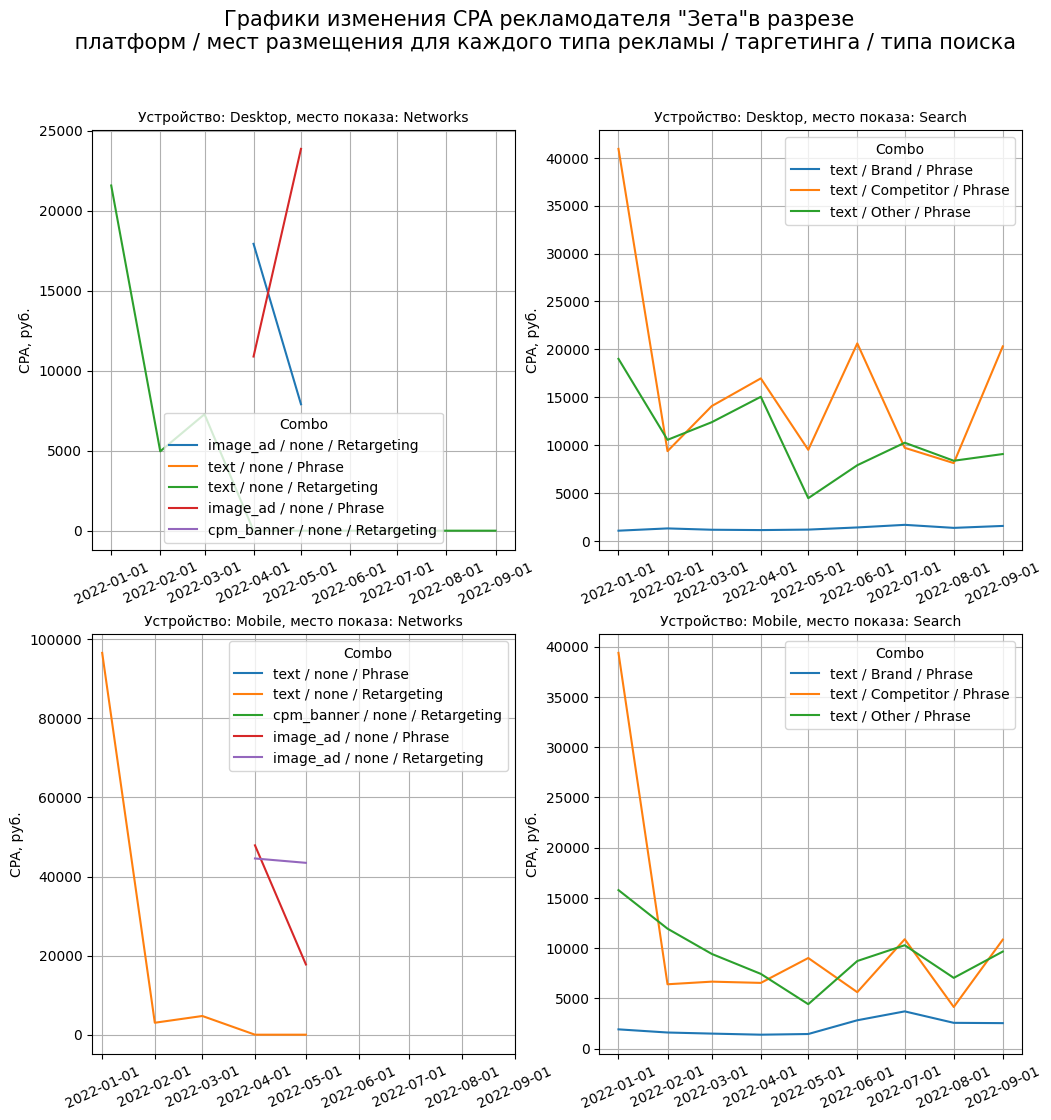

In [26]:
# Подготовим данные для графиков - используем только фильтрацию, т.к. данные уже агрегированы по месяцам и рекламным объявлениям
cpa_each_branch = df[(df['Client'] == 'Зета')\
                   & (df['Month'] > '2021-12-01')\
                   & (df['Category'] == 'РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ')]\

# Рассчитаем СРА
cpa_each_branch['CPA'] = cpa_each_branch['Cost'] / cpa_each_branch['Conversions']

# Подготовим обозначения для каждого типа рекламного объявления
cpa_each_branch['Combo'] = cpa_each_branch[['BannerType','QueryType (search only)', 'TargetingType']]\
                                            .apply(lambda x :' / '.join(x.astype(str)),1)

# Создадим словарь с параметрами для каждого графика
param_dict = {1: [0, 0, 'Device', 'Desktop', 'Place', 'Networks'],
              2: [0, 1, 'Device', 'Desktop', 'Place', 'Search'],
              3: [1, 0, 'Device', 'Mobile', 'Place', 'Networks'],
              4: [1, 1, 'Device', 'Mobile', 'Place', 'Search']}

# Построим графики
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 12))
fig.suptitle('Графики изменения CPA рекламодателя "Зета"в разрезе \n платформ / мест размещения для каждого типа рекламы / таргетинга / типа поиска',\
            size = 15)


for key, value in param_dict.items():
    
    # Построим сами графики в разрезах платформы и места размещения рекламы
    sns.lineplot(x = 'Month', y = 'CPA', hue = 'Combo',\
                 data = cpa_each_branch[(cpa_each_branch[value[2]] == value[3])\
                                      & (cpa_each_branch[value[4]] == value[5])], ax=axs[value[0], value[1]])
    
    # Зададим параметры для каждого графика
    # Подписи осей
    axs[value[0], value[1]].set(xlabel = None, ylabel = 'CPA, руб.')
    
    # Текст заголовка
    title = 'Устройство: ' +  value[3] + ', место показа: ' + value[5]
    
    # Зададим сам заголовок
    axs[value[0], value[1]].set_title(title, size=10)
    
    # Повернем значения оси X
    axs[value[0], value[1]].xaxis.set_ticks(list(pd.DatetimeIndex(cpa_each_branch['Month'].unique()).date.astype(str)))
    axs[value[0], value[1]].set_xticklabels(pd.DatetimeIndex(cpa_each_branch['Month'].unique()).date.astype(str), rotation = 25)
    
    # Зададим сетку для каждого графика
    axs[value[0], value[1]].grid(True) 
    
plt.show()

У "Гамма" нет показов в Интернете (РСЯ), поэтому значения СРА только данного рекламодателя нельзя использовать в качестве ориентира. А для "Зета" значения следующие (для всех типов объявлений):
- ПК:
    - Интернет (РСЯ): СРА = 20 000 руб.;
    - Поиск: СРА = 20 000 руб.;
- Телефон:
    - Интернет (РСЯ): СРА = 45 000 руб.;
    - Поиск: СРА = 10 000 руб.
    
Если опираться на эти значения, то можно сделать следующие выводы по рекламе "Сигма":
- ПК:
    - Интернет (РСЯ): СРА = 20 000 руб. (все в норме);
    - Поиск: СРА = 10 000 руб. (**кроме mcbanner / Brand, СРА для которого равен 30 000 руб. и выбивается из общей картины**);
- Телефон:
    - Интернет (РСЯ): СРА = 400 000 руб. (проблемные объявления, как было выявлено ранее);
    - Поиск: СРА = 12 500 руб. (**кроме text, CPA для которого выходит за рамки 20 000 руб.**).

**Выводы:** на данный момент есть несколько уровней проблематики:
- общая проблематика по группа объявлений "РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ" - высокий уровень CPA:
- самая большая проблема по следующим подгруппам объявлений: 
    - тип устройства - телефон;
    - место размещения рекламы - Networks (Интернет, РСЯ);
    - типы рекламы - text ("текстовый") и image_ad / Retargeting ("текст + изображение / Повторные показы рекламы"; показы прекратились после августа 2022);
- типы объявлений, которые можно улучшить после решения основной проблемы:
    - ПК / Поиск / mcbanner / Brand;
    - Телефон / Поиск / Текст
    
Проверка (построение графиков CPA для каждого типа рекламы) проблему подтвердило: CPA для указанных выше типов рекламы очень сильно выделяются на фоне остальных.    
    
Чтобы выявить проблематику сайта или проблемы с рекламой, а также дать более точные рекомендации для устранения проблемы, проверим воронку действий, совершаемых пользователями, пришедшими по данной группе объявлений.    

### Работа с воронкой продукта

В нашем случае воронка продукта выглядит следующим образом:

`Кол-во целевых визитов = Кол-во показов * Конверсия показа в клики (CTR) * Коэффициент конверсии (CR)`:
- Кол-во показов (Shows) - известная нам величина;
- **Конверсия показа в клики (кликабельность, CTR: от англ. Click-Through Rate)** - это отношение числа кликов на объявление к числу его показов. Отражает эффективность настройки рекламы;
- **Коэффициент конверсии (CR)** — отношение количества целевых визитов к общему количеству визитов (числу кликов). Отражает качество сайта, простоту пути до целевого действия.

#### Измерение CTR и CR для группы объявлений 

Построим динамику изменения конверсий для группы объявлений "РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ":

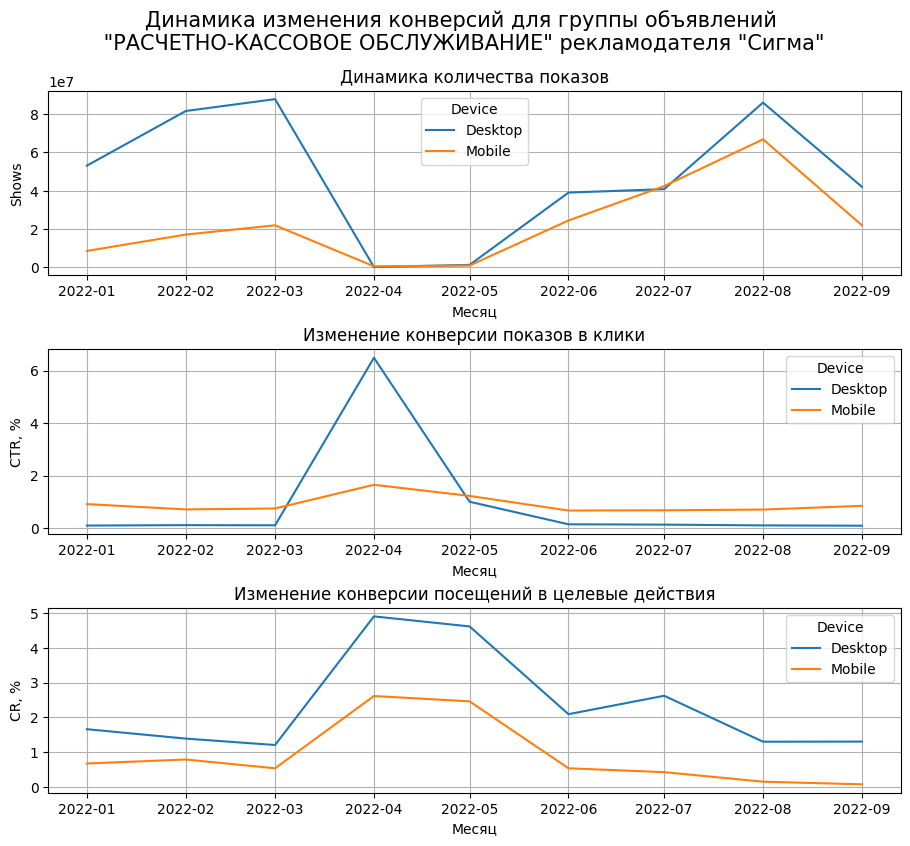

In [27]:
# Подготовим данные
conv_platform_chart_sigma = df[(df['Client'] == 'Сигма')\
                               & (df['Month'] > '2021-12-01')\
                               & (df['Category'] == 'РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ')]\
                            .groupby(['Month', 'Device'], as_index = False)\
                            .agg({'Shows': 'sum', 'Clicks': 'sum', 'Conversions': 'sum'})
# Посчитаем CTR
conv_platform_chart_sigma['CTR, %'] = conv_platform_chart_sigma['Clicks'] / conv_platform_chart_sigma['Shows'] * 100

# Посчитаем CR
conv_platform_chart_sigma['CR, %'] = conv_platform_chart_sigma['Conversions'] / conv_platform_chart_sigma['Clicks'] * 100

# Создадим словарь с параметрами для каждого графика
param_dict = {1: ['Shows', 'Динамика количества показов'],
              2: ['CTR, %', 'Изменение конверсии показов в клики'], 
              3: ['CR, %', 'Изменение конверсии посещений в целевые действия']}

# Построим линейные графики
# Зададим фигуры и их параметры, на которых расположим наши графики
fig, axs = plt.subplots(3, 1, figsize = (11, 9))
fig.suptitle('Динамика изменения конверсий для группы объявлений\n "РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ" рекламодателя "Сигма"',\
             fontsize = 15)
plt.subplots_adjust(top = 0.89, hspace = 0.4)

#Построим графики
for key, value in param_dict.items():
    sns.lineplot(x = 'Month', y = value[0], hue = 'Device', data = conv_platform_chart_sigma, ax=axs[key - 1])
    
    # Зададим значения оси X и сетку для каждого графики 
    axs[key - 1].set(title = value[1], xlabel = 'Месяц')
    axs[key - 1].grid(True)
    
#Выведем получившиеся графики на экран
plt.show()

In [28]:
# Посчитаем медианные значения конверсий
for device in (['Mobile', 'Desktop']):
    for param in (['Shows', 'CTR, %', 'CR, %']):
        param_value = round(conv_platform_chart_sigma[(conv_platform_chart_sigma['Device'] == device)][param].median(), 2)
        print(f'Для платформы {device} медианное значение {param} = {param_value}')

Для платформы Mobile медианное значение Shows = 21961836.0
Для платформы Mobile медианное значение CTR, % = 0.75
Для платформы Mobile медианное значение CR, % = 0.54
Для платформы Desktop медианное значение Shows = 42075052.0
Для платформы Desktop медианное значение CTR, % = 0.12
Для платформы Desktop медианное значение CR, % = 1.66


На входе в воронку показов порядка 20 - 60 млн. (2-8 le7), CTR на обоих устройствах ниже 1% (за исключением пика в апреле 2022 г.). CR выше на ПК, на телефонах - также ниже 1%, исключая пИковые значения.

#### Расчет конверсий рекламодателей-конкурентов с самым низким СРА для оценки метрик воронки

Для сравнения рассмотрим конверсию по группе объявлений "РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ" у рекламодателя-конкуренте "Зета" (у него один из самых эффективных средних CPA и представленность во всех типах рекламы):

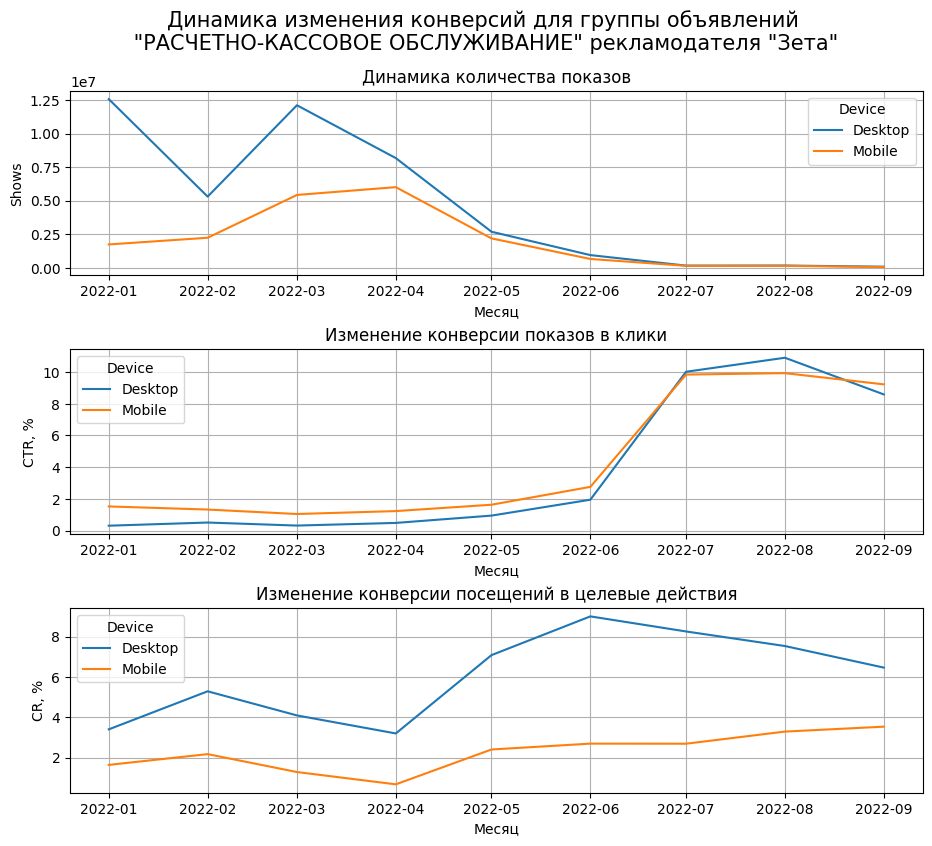

In [29]:
# Подготовим данные
conv_platform_chart_zeta = df[(df['Client'] == 'Зета')\
                            & (df['Month'] > '2021-12-01')\
                            & (df['Category'] == 'РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ')]\
                            .groupby(['Month', 'Device'], as_index = False)\
                            .agg({'Shows': 'sum', 'Clicks': 'sum', 'Conversions': 'sum'})
# Посчитаем CTR
conv_platform_chart_zeta['CTR, %'] = conv_platform_chart_zeta['Clicks'] / conv_platform_chart_zeta['Shows'] * 100

# Посчитаем CR
conv_platform_chart_zeta['CR, %'] = conv_platform_chart_zeta['Conversions'] / conv_platform_chart_zeta['Clicks'] * 100

# Создадим словарь с параметрами для каждого графика
param_dict = {1: ['Shows', 'Динамика количества показов'],
              2: ['CTR, %', 'Изменение конверсии показов в клики'], 
              3: ['CR, %', 'Изменение конверсии посещений в целевые действия']}

# Построим линейные графики
# Зададим фигуры и их параметры, на которых расположим наши графики
fig, axs = plt.subplots(3, 1, figsize = (11, 9))
fig.suptitle('Динамика изменения конверсий для группы объявлений\n "РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ" рекламодателя "Зета"',\
             fontsize = 15)
plt.subplots_adjust(top = 0.89, hspace = 0.4)

#Построим графики
for key, value in param_dict.items():
    sns.lineplot(x = 'Month', y = value[0], hue = 'Device', data = conv_platform_chart_zeta, ax=axs[key - 1])
    
    # Зададим значения оси X и сетку для каждого графики 
    axs[key - 1].set(title = value[1], xlabel = 'Месяц')
    axs[key - 1].grid(True)
    
#Выведем получившиеся графики на экран
plt.show()

In [30]:
# Посчитаем медианные значения конверсий у Зета
for device in (['Mobile', 'Desktop']):
    for param in (['Shows', 'CTR, %', 'CR, %']):
        param_value = round(conv_platform_chart_zeta[(conv_platform_chart_zeta['Device'] == device)][param].median(), 2)
        print(f'Для платформы {device} медианное значение {param} = {param_value}')

Для платформы Mobile медианное значение Shows = 1739520.0
Для платформы Mobile медианное значение CTR, % = 1.63
Для платформы Mobile медианное значение CR, % = 2.41
Для платформы Desktop медианное значение Shows = 2685952.0
Для платформы Desktop медианное значение CTR, % = 0.95
Для платформы Desktop медианное значение CR, % = 6.46


CTR:
- для телефонов - чуть ниже 2 %, последние 2 месяца - на уровне 8-10 %;
- для ПК - на уровне 1 %, последние 2 месяца - на уровне 8-10%;

CR:
- для телефонов - на уровне 2 - 2,5 %;
- для ПК - стабильно выше 4%, последние 3 месяца - на уровне 7-8 %.

Очевидно, что в целом показатели конверсии для группы объявлений "РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ" у рекламодателя "Зета" лучше, чем у "Сигма" - на них и будем ориентироваться. 

#### Проверка конверсий для проблемных подгрупп объявлений

Зная, на какие значения CTR и CR ориентироваться, проверим конверсию для проблемных подгрупп объявлений:
- категория - "РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ";
- тип устройства - телефон;
- места раземещения - Поиск и Интернет (РСЯ):

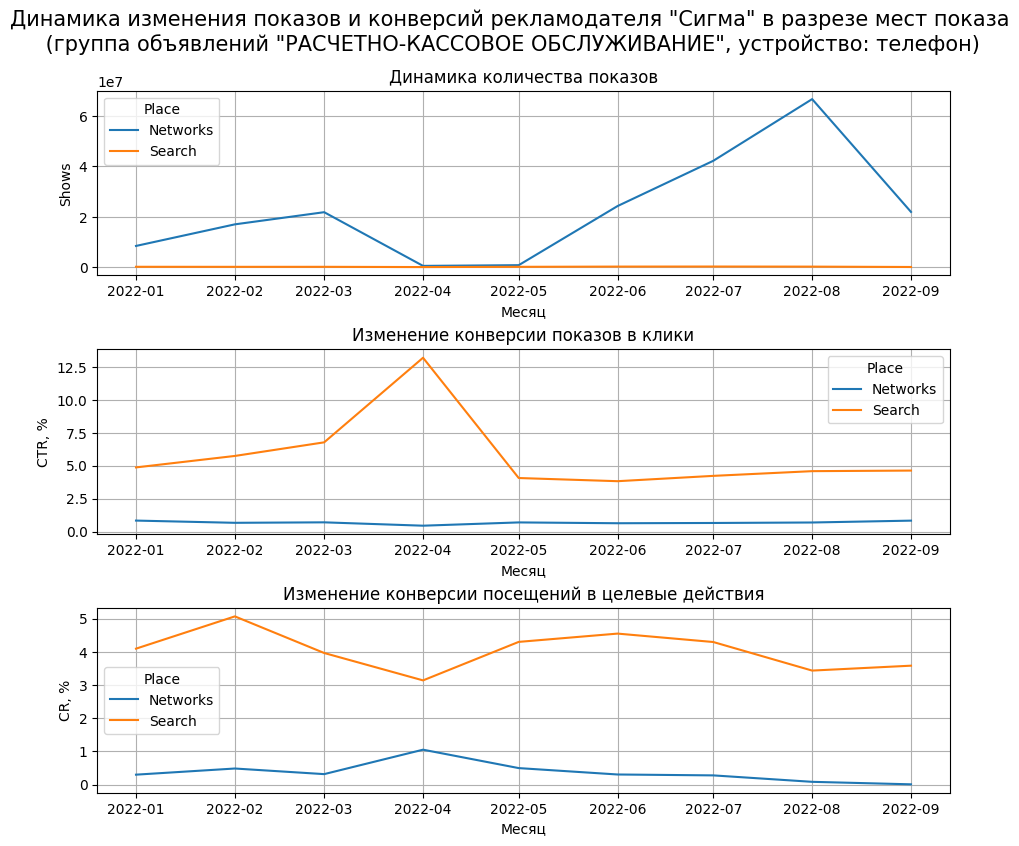

In [31]:
# Подготовим данные
conv_platform_chart_sigma = df[(df['Client'] == 'Сигма')
                               & (df['Month'] > '2021-12-01')\
                               & (df['Category'] == 'РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ')
                               & (df['Device'] == 'Mobile')]\
                            .groupby(['Month','Place'], as_index = False).agg({'Shows': 'sum', 'Clicks': 'sum', 'Conversions': 'sum'})
# Посчитаем CTR
conv_platform_chart_sigma['CTR, %'] = conv_platform_chart_sigma['Clicks'] / conv_platform_chart_sigma['Shows'] * 100

# Посчитаем CR
conv_platform_chart_sigma['CR, %'] = conv_platform_chart_sigma['Conversions'] / conv_platform_chart_sigma['Clicks'] * 100

# Построим линейные графики
# Зададим фигуры и их параметры, на которых расположим наши графики
fig, axs = plt.subplots(3, 1, figsize = (11, 9))
fig.suptitle('Динамика изменения показов и конверсий рекламодателя "Сигма" в разрезе мест показа\n (группа объявлений \
"РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ", устройство: телефон)', fontsize = 15)
plt.subplots_adjust(top = 0.89, hspace = 0.4)

#Построим графики
for key, value in param_dict.items():
    sns.lineplot(x = 'Month', y = value[0], hue = 'Place', data = conv_platform_chart_sigma, ax=axs[key - 1])
    
    # Зададим значения оси X и сетку для каждого графики 
    axs[key - 1].set(title = value[1], xlabel = 'Месяц')
    axs[key - 1].grid(True)
    
#Выведем получившиеся графики на экран
plt.show()

In [32]:
# Посчитаем медианные значения конверсий для телефонов в разрезе мест показа
for place in (['Networks', 'Search']):
    for param in (['Shows', 'CTR, %', 'CR, %']):
        param_value = round(conv_platform_chart_sigma[(conv_platform_chart_sigma['Place'] == place)][param].median(), 2)
        print(f'Для платформы "Mobile" и места показа "{place}" медианное значение {param} = {param_value}')

Для платформы "Mobile" и места показа "Networks" медианное значение Shows = 21810177.0
Для платформы "Mobile" и места показа "Networks" медианное значение CTR, % = 0.7
Для платформы "Mobile" и места показа "Networks" медианное значение CR, % = 0.3
Для платформы "Mobile" и места показа "Search" медианное значение Shows = 151659.0
Для платформы "Mobile" и места показа "Search" медианное значение CTR, % = 4.63
Для платформы "Mobile" и места показа "Search" медианное значение CR, % = 4.09


У рекламных объявлений, размещаемых в поисковой строке, достаточно высокая конверсия - как для CTR, так и для CR.

А проблемными являются все объявления, показываемые в Интернете (РСЯ). Поэтому рассмотрим дальше, какие из конкретных объявлений оказались самыми неэффективными - построим графики в разрезе типов объявлений / типов таргетинга:

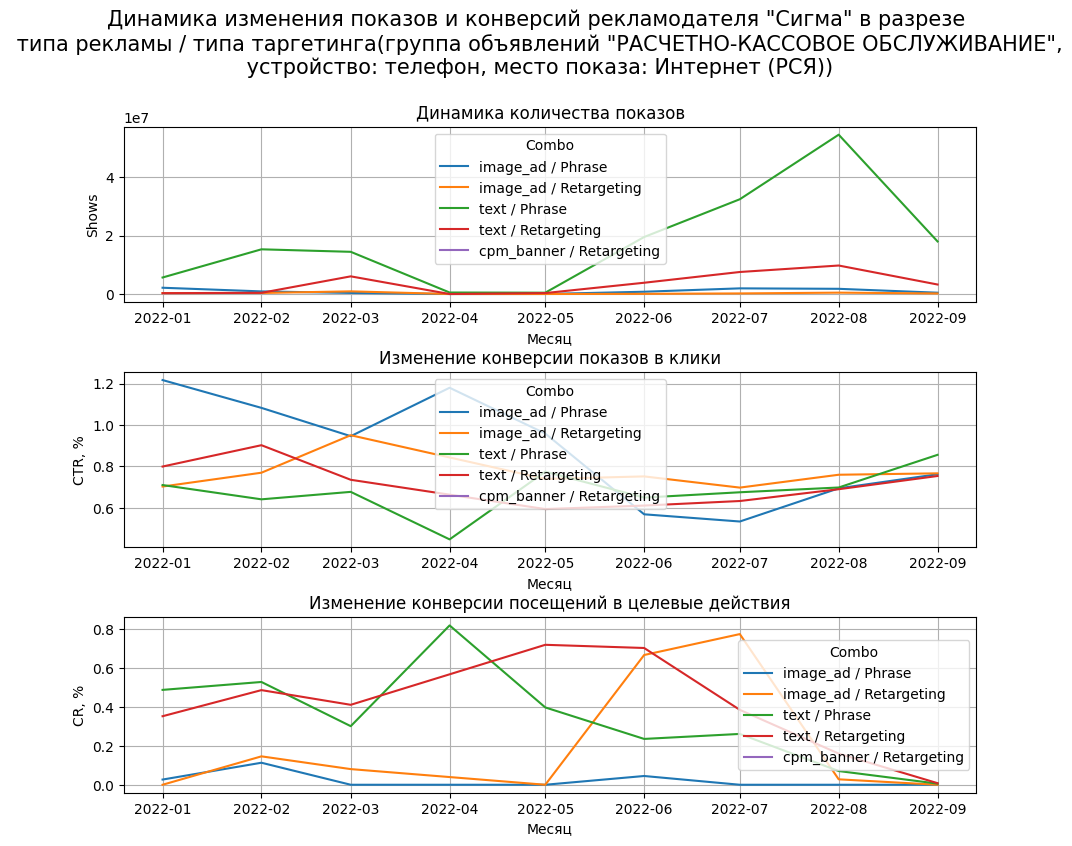

In [33]:
# Подготовим данные
conv_platform_chart_sigma = df[(df['Client'] == 'Сигма')
                               & (df['Month'] > '2021-12-01')
                               & (df['Category'] == 'РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ')
                               & (df['Device'] == 'Mobile')
                               & (df['Place'] == 'Networks')]\
                            .groupby(['Month','BannerType', 'TargetingType'], as_index = False)\
                            .agg({'Shows': 'sum', 'Clicks': 'sum', 'Conversions': 'sum'})
# Посчитаем CTR
conv_platform_chart_sigma['CTR, %'] = conv_platform_chart_sigma['Clicks'] / conv_platform_chart_sigma['Shows'] * 100

# Посчитаем CR
conv_platform_chart_sigma['CR, %'] = conv_platform_chart_sigma['Conversions'] / conv_platform_chart_sigma['Clicks'] * 100

# Создадим названия для графиков
conv_platform_chart_sigma['Combo'] = conv_platform_chart_sigma[['BannerType', 'TargetingType']]\
                                            .apply(lambda x :' / '.join(x.astype(str)),1)

# Построим линейные графики
# Зададим фигуры и их параметры, на которых расположим наши графики
fig, axs = plt.subplots(3, 1, figsize = (11, 9))
fig.suptitle('Динамика изменения показов и конверсий рекламодателя "Сигма" в разрезе\n типа рекламы / типа таргетинга\
(группа объявлений "РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ",\n устройство: телефон, место показа: Интернет (РСЯ))', fontsize = 15)
plt.subplots_adjust(top = 0.85, hspace = 0.4)

#Построим графики
for key, value in param_dict.items():
    sns.lineplot(x = 'Month', y = value[0], hue = 'Combo', data = conv_platform_chart_sigma, ax=axs[key - 1])
    
    # Зададим значения оси X и сетку для каждого графики 
    axs[key - 1].set(title = value[1], xlabel = 'Месяц')
    axs[key - 1].grid(True)
    
#Выведем получившиеся графики на экран
plt.show()

In [34]:
# Посчитаем медианные значения конверсий для телефонов / место показа: Интернет в разрезе типов рекламы / таргетинга
for advertisment in (['image_ad / Phrase', 'image_ad / Retargeting', 'text / Phrase', 'text / Retargeting']):
    for param in (['Shows', 'CTR, %', 'CR, %']):
        param_value = round(conv_platform_chart_sigma[(conv_platform_chart_sigma['Combo'] == advertisment)][param].median(), 2)
        print(f'Для платформы "Mobile", места показа "Networks" и типа рекламы "{advertisment}" медианное значение {param}\
 = {param_value}')
    print('-------------------------------------------------------------------------------------------------------------------')
    print()

Для платформы "Mobile", места показа "Networks" и типа рекламы "image_ad / Phrase" медианное значение Shows = 781123.0
Для платформы "Mobile", места показа "Networks" и типа рекламы "image_ad / Phrase" медианное значение CTR, % = 0.95
Для платформы "Mobile", места показа "Networks" и типа рекламы "image_ad / Phrase" медианное значение CR, % = 0.0
-------------------------------------------------------------------------------------------------------------------

Для платформы "Mobile", места показа "Networks" и типа рекламы "image_ad / Retargeting" медианное значение Shows = 203607.0
Для платформы "Mobile", места показа "Networks" и типа рекламы "image_ad / Retargeting" медианное значение CTR, % = 0.76
Для платформы "Mobile", места показа "Networks" и типа рекламы "image_ad / Retargeting" медианное значение CR, % = 0.08
-------------------------------------------------------------------------------------------------------------------

Для платформы "Mobile", места показа "Networks" и ти

Как и было выявлено ранее, самая большая проблема по следующим подгруппам объявлений:
- тип устройства - телефон;
- место размещения рекламы - Networks (Интернет, РСЯ);
- типы рекламы - text ("текстовый") и image_ad / Retargeting ("текст + изображение / Повторные показы рекламы").

подтвердилась: CTR в диапазоне 0.68-0.95 %, CR - 0 - 0.41 %.

#### Определение самой эффективной подгруппы в группе объявлений "РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ"

При проверке конверсий для проблемных подгрупп объявлений было выявлено, что самая высокая эффективность объявлений была в поиске. Но у поля Search есть только одна подгруппа - тип запроса QueryType. Построим графики конверсий в разрезе типов запросов для мобильных телефонов:  

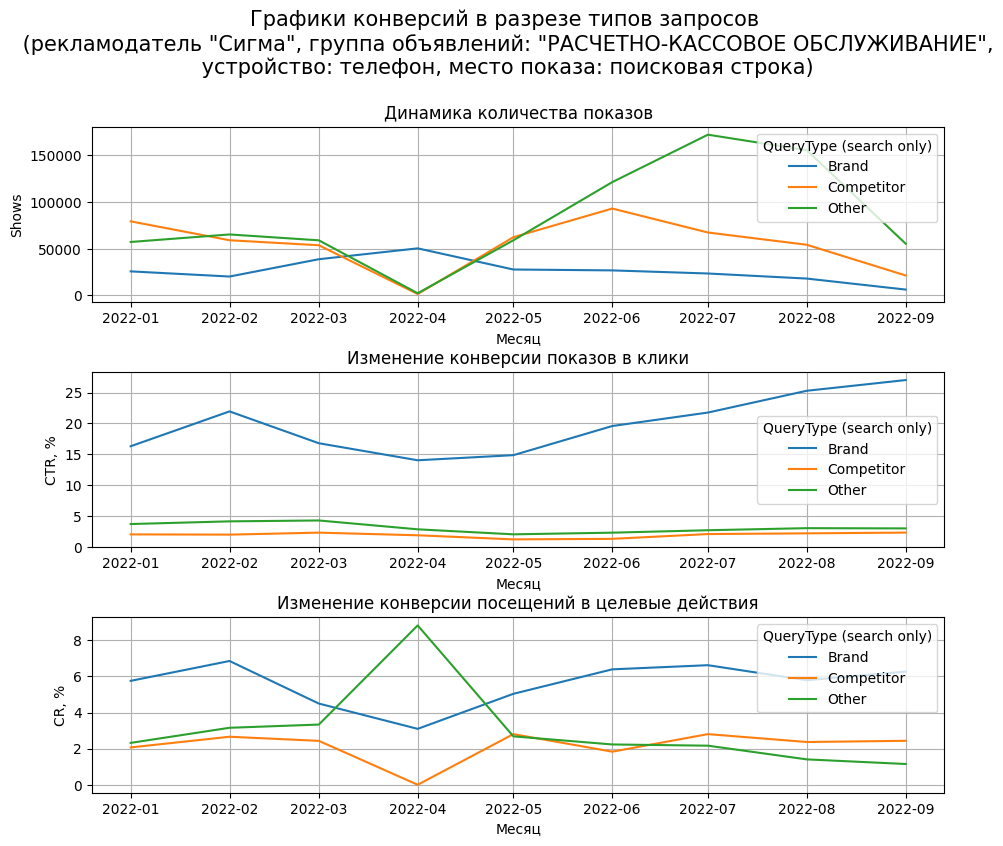

In [35]:
# Подготовим данные
conv_platform_chart_sigma = df[(df['Client'] == 'Сигма')\
                               & (df['Month'] > '2021-12-01')\
                               & (df['Category'] == 'РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ')
                               & (df['Device'] == 'Mobile')
                               & (df['Place'] == 'Search')]\
                            .groupby(['Month', 'QueryType (search only)']).agg({'Shows': 'sum', 'Clicks': 'sum', 'Conversions': 'sum'})
# Посчитаем CTR
conv_platform_chart_sigma['CTR, %'] = conv_platform_chart_sigma['Clicks'] / conv_platform_chart_sigma['Shows'] * 100

# Посчитаем CR
conv_platform_chart_sigma['CR, %'] = conv_platform_chart_sigma['Conversions'] / conv_platform_chart_sigma['Clicks'] * 100

# Создадим словарь с параметрами для каждого графика
param_dict = {1: ['Shows', 'Динамика количества показов'],
              2: ['CTR, %', 'Изменение конверсии показов в клики'], 
              3: ['CR, %', 'Изменение конверсии посещений в целевые действия']}

# Построим линейные графики
# Зададим фигуры и их параметры, на которых расположим наши графики
fig, axs = plt.subplots(3, 1, figsize = (11, 9))
fig.suptitle('Графики конверсий в разрезе типов запросов\n (рекламодатель "Сигма", группа объявлений: \
"РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ",\n устройство: телефон, место показа: поисковая строка)', fontsize = 15)
plt.subplots_adjust(top = 0.85, hspace = 0.4)

#Построим графики
for key, value in param_dict.items():
    sns.lineplot(x = 'Month', y = value[0], hue = 'QueryType (search only)', data = conv_platform_chart_sigma, ax=axs[key - 1])
    
    # Зададим значения оси X и сетку для каждого графики 
    axs[key - 1].set(title = value[1], xlabel = 'Месяц')
    axs[key - 1].grid(True)
    
#Выведем получившиеся графики на экран
plt.show()

При поисковых показах по **бренду** "Сигма" с мобильных устройств CTR составляет порядка 15-25 %, а CR на уровне 6 %. Проверим то же самое для ПК:

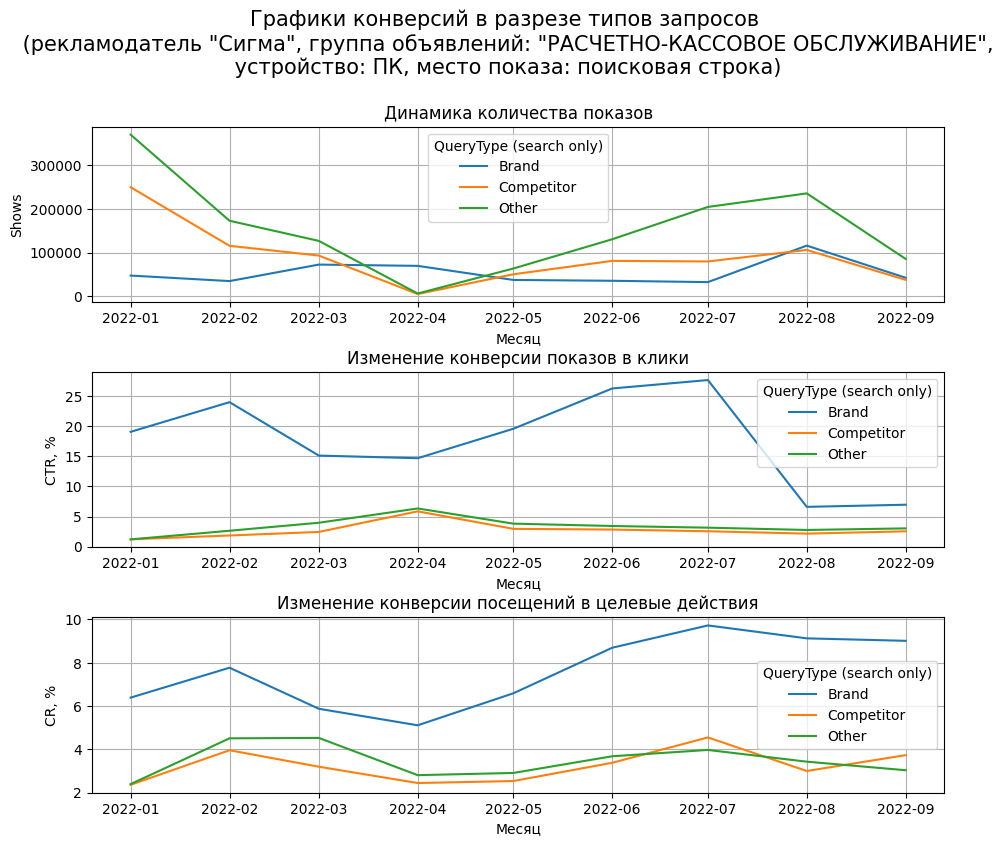

In [36]:
# Подготовим данные
conv_platform_chart_sigma = df[(df['Client'] == 'Сигма')\
                               & (df['Month'] > '2021-12-01')\
                               & (df['Category'] == 'РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ')
                               & (df['Device'] == 'Desktop')
                               & (df['Place'] == 'Search')]\
                            .groupby(['Month', 'QueryType (search only)']).agg({'Shows': 'sum', 'Clicks': 'sum', 'Conversions': 'sum'})
# Посчитаем CTR
conv_platform_chart_sigma['CTR, %'] = conv_platform_chart_sigma['Clicks'] / conv_platform_chart_sigma['Shows'] * 100

# Посчитаем CR
conv_platform_chart_sigma['CR, %'] = conv_platform_chart_sigma['Conversions'] / conv_platform_chart_sigma['Clicks'] * 100

# Создадим словарь с параметрами для каждого графика
param_dict = {1: ['Shows', 'Динамика количества показов'],
              2: ['CTR, %', 'Изменение конверсии показов в клики'], 
              3: ['CR, %', 'Изменение конверсии посещений в целевые действия']}

# Построим линейные графики
# Зададим фигуры и их параметры, на которых расположим наши графики
fig, axs = plt.subplots(3, 1, figsize = (11, 9))
fig.suptitle('Графики конверсий в разрезе типов запросов\n (рекламодатель "Сигма", группа объявлений: \
"РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ",\n устройство: ПК, место показа: поисковая строка)', fontsize = 15)
plt.subplots_adjust(top = 0.85, hspace = 0.4)

#Построим графики
for key, value in param_dict.items():
    sns.lineplot(x = 'Month', y = value[0], hue = 'QueryType (search only)', data = conv_platform_chart_sigma, ax=axs[key - 1])
    
    # Зададим значения оси X и сетку для каждого графики 
    axs[key - 1].set(title = value[1], xlabel = 'Месяц')
    axs[key - 1].grid(True)
    
#Выведем получившиеся графики на экран
plt.show()

Для ПК ситуация также обстоит лучше, чем в целом по группе объявлений "РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ".

Так как для мобильных устройств CTR растет, то рассчитаем CPA для этой подгруппы:
- тип устройства: **телефон**;
- тип площадки: поиск;
- тип рекламного объявления (баннера): "текст";
- тип поискового запроса: "Бренд":

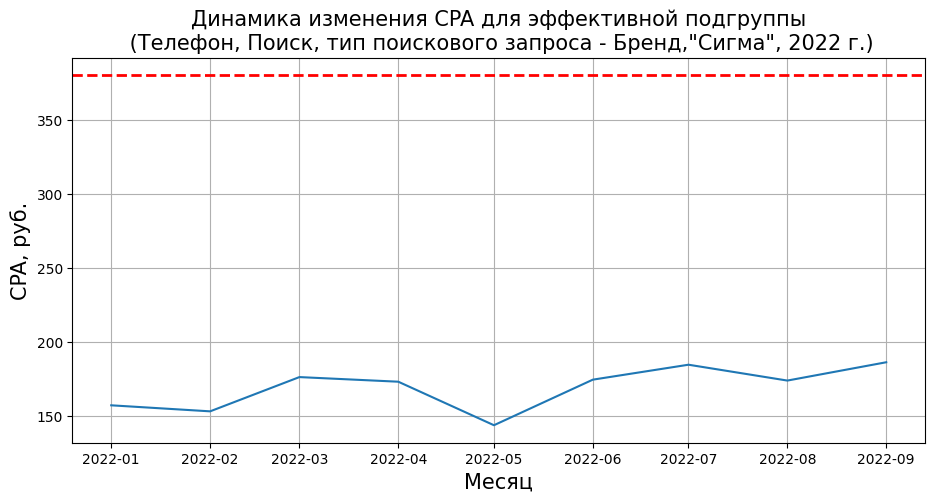

In [37]:
# Подготовим данные для построения графика изменения CPA 
effective_subgroup_cpa = df[(df['Client'] == 'Сигма')\
                           & (df['Month'] > '2021-12-01')\
                           & (df['Device'] == 'Mobile')\
                           & (df['Place'] == 'Search')\
                           & (df['BannerType'] == 'text')\
                           & (df['QueryType (search only)'] == 'Brand') ]\
                        .groupby('Month', as_index = False).agg({'Clicks': 'sum', 'Cost': 'sum', 'Conversions': 'sum'})

# Рассчитаем CPA
effective_subgroup_cpa['CPA'] = effective_subgroup_cpa['Cost'] / effective_subgroup_cpa['Conversions']

# Построим линейный график
plt.figure(figsize = (11, 5))
ax = sns.lineplot(x = effective_subgroup_cpa['Month'], y = np.array(effective_subgroup_cpa['CPA']))
plt.title('Динамика изменения CPA для эффективной подгруппы\n (Телефон, Поиск, тип поискового запроса - Бренд,\
"Сигма", 2022 г.)', fontsize = 15)
plt.xlabel('Месяц', fontsize = 15)
plt.ylabel('CPA, руб.', fontsize = 15)
plt.grid()

# Добавим индикатор целевого значения CPA
plt.axhline(y=380, color='r', linestyle='dashed', linewidth=2)
plt.show()

Для данной подгруппы объявлений СРА является одним из самых низких, а также ниже целевого уровня Заказчика - "на руку" играет узнаваемость бренда.

## Выводы и рекомендации по результатам исследования

Общие выводы об исследовании:
- организован хороший сбор данных: нет пропусков, большинство значений интуитивно понятны;
- в исследовании речь идет об одном целевом действии рекламодателя;
- СРА для рекламной группы "РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ" по отрасли достаточно высокий (на уровне 15 000 - 20 000 руб. у самых эффективных рекламодателей), что является нормой.

Основной причиной роста среднего CPA является рост СРА по группе объявлений "РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ". Превышение заданного СРА в разы наблюдается практически по всем подгруппам / разрезам данных:
- по устройствам показа: телефон и ПК;
- по типу площадки: поиск и Интернет (РСЯ);
- по типам рекламного объявления (баннера): "текст" и "текст + изображение";
- по типам таргетинга: "ключевые фразы" и "ретаргетинг".

Самыми проблемными рекламными объявлениями (СРА 100 000 - 380 000 руб.) являются:
- тип устройства: **телефон**;
- тип площадки: Интернет (РСЯ);
- типы рекламного объявления (баннера):
    - "текст" (типы таргетинга: ключевые фразы + ретаргетинг);
    - "текст + изображение" (ретаргетинг).

По следующим рекламным обявлениям СРА выходит за рамки лучших показателей у конкурентов (30 000 - 40 000 руб. против 15 000 - 20 000 руб.) - поэтому их можно будет улучшить:
- группа объявлений: "РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ";
- тип устройства:
    - ПК:
        - место показа: Поиск;
        - тип объявления: mcbanner / Brand, СРА для которого равен 30 000 руб. против среднего 10 000 руб.;
    - Телефон:
        - место показа: Поиск;
        - тип объявления: "текст / Другой (Other)" СРА для которого равен 20 000 руб. против среднего 12 500 руб.

Самой эффективной подгруппой (CPA на уровне в 170 руб.) в группе объявлений "РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ" является:
- тип устройства: **телефон**;
- тип площадки: поиск;
- тип рекламного объявления (баннера): "текст";
- тип поискового запроса: "Бренд".

Показы есть по всем подгруппам, а высокий СРА обусловлен в основном одновременно низкими CTR и CR. 
Это может говорить о том, что:
- есть проблема в целом по группе объявлений "РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ". Целиком на эту группу может влиять настройка "ключевых фраз" и "минус-слов", заголовков и изображений (для типа рекламного объявления "текст + изображение");
- объявления показываются не тому сегменту пользователей;
- объявления оформлены неверно (банальная ошибка).
    
Рекомендации:
- если решение необходимо быстро, то можно отключить показы объявлений из данной группы;
- в первую очередь проверить настройки рекламы для самой проблемной группы;
- глобально, на уровне группы объявлений "РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ" -  проверить ключевые фразы и минус-слова (это может влиять разом на все объявления);
- проверить настройки рекламных объявлений для **"РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ" / ПК / Поиск / mcbanner / Brand** и **"РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ" / Телефон / Поиск / text / Other**.